# Project Assignment B

## 1. Motivation

### 1.1 What is your dataset?
For the project, we are using
- [Daily COVID-19 data](https://covidtracking.com/api/v1/states/daily.csv)
    - Source: Covidtracking.com
    - Includes COVID-19 related metrics, such as the number of positive tests, deaths and hospitalizations for each state.
- [General socioeconomic data](https://www.kaggle.com/nightranger77/covid19-state-data)
    - Source: Kaggle, data compiled from multiple sources, like World Population Review, Kaiser Family Foundation and Wikipedia.
    - Includes properties like GDP per capita, inequality, mean temperature and other factors for each state.
- [County-level, extended socioeconomic data](https://www.kaggle.com/johnjdavisiv/us-counties-covid19-weather-sociohealth-data/version/15)
    - Source: Kaggle, data compiled from multiple sources.
    - Includes 181 columns of data ranging from ranging from ethnical composition, to vehicle ownership.
- [Weekly unemployment data](https://oui.doleta.gov/unemploy/claims.asp)
    - Source: U.S. Department of Labor
    - Contains unemployment data for each state, reported on a weekly basis.

### 1.2  Why did you choose this/these particular dataset(s)?
We would like to build a visualization that represents the course of the COVID-19 outbreak in the United States, and explores the possible factors behind the virus' diverse effects on U.S. states.
For instance, it is well known that New York has orders of magnitude more infections and deaths than some states in the U.S. Midwest, and it is very likely that this anomaly is an effect of complex socio-economic factors.

The datasets we have chosen provide us the necessary epidemiological and socioeconomic information to carry out the above exploration. We were usually aiming at finding data originating from official sources (e.g. government agencies), but sometimes we had to resort on using data that somebody has already complied from multiple sources (this is the case with most of the Kaggle datasets).

### 1.3 What was your goal for the end user's experience?
Our goal was to present our findings to the end user by gradually moving into the details. The visualization begins with an interactive map of the U.S, representing the spread of the virus with the advance of time. This provides the user with a summary of the pandemic's temporal and spatial patterns. The map is followed by visualizations that explain the likely factors behind these patterns. Finally, given this knowledge, the user is presented some use-cases in which we exploit the explored relationships by means of machine learning.

## 2. Basic stats, data preparation

In [1]:
#import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats
import matplotlib as mpl
import bokeh
import datetime
from apyori import apriori

### 2.1 COVID-19 data
The dataset contains daily COVID-19 data for each state recorded between the 22th of January and 3th May. It includes a total of
- 25 variables
- 3076 records,

that represent the COVID-19 status of a given state on a given day. The variables include the number of positive and negative tests, number of hospitalized people, ICU patients and people on ventilators to date.

In [2]:
df_daily = pd.read_csv('us_states_daily_covid19.csv')
df_daily.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200503,AK,368.0,21210.0,NaN,12.0,NaN,NaN,NaN,NaN,...,NaN,21578.0,21578.0,21578.0,2,0.0,0.0,176.0,3.0,179.0
1,20200503,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,403.0,NaN,...,1035.0,92500.0,92500.0,92500.0,1,2.0,12.0,0.0,291.0,291.0
2,20200503,AR,3431.0,49459.0,NaN,100.0,427.0,NaN,NaN,20.0,...,427.0,52890.0,52890.0,52890.0,5,3.0,13.0,1249.0,59.0,1308.0
3,20200503,AS,0.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,57.0,57.0,57.0,60,0.0,0.0,0.0,0.0,0.0
4,20200503,AZ,8640.0,72479.0,NaN,732.0,1348.0,282.0,NaN,192.0,...,1348.0,81119.0,81119.0,81119.0,4,14.0,9.0,2846.0,276.0,3122.0


By inspecting the dataset, it becomes apparent that many values are missing, this is due the fact that some states only started reporting cases as the coronavirus arrived there. Therefore it makes sense to replace those missing data with zeros. There are also weirdly-formatted columns, like the date column, that is just a string of numbers without any delimiter. Also, there are small cosmetical issues, like the names of the states being incomprehensible. Furthermore, the dataset includes data about some overseas territories, like Puerto Rico or the Virgin Islands, that we do not want to include into our analysis.

In [3]:
# Define the overseas territories that we don not want to include
no_states = ['AS','GU','MP','PR','VI']

# Drop records that include one of these territories
for no_state in no_states:
    df_daily = df_daily.drop(df_daily[(df_daily['state'] == no_state)].index)

# Transform the dataset so that state IDs become human-readable
states = {"AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California","CO":"Colorado","CT":"Connecticut","DC":"District of Columbia","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland","MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana","NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont","VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"}
def func_state(row):
    return states[row['state']]

df_daily['state'] = df_daily.apply(func_state, axis=1)

# Define a function that formats date strings into the standard representation
def func_date(row):
    return "{}-{}-{}".format(row['date'][:4], row['date'][4:6], row['date'][6:])

# Transform the date column into string, as they are initially numbers
df_daily['date'] = df_daily['date'].astype(str)

# Apply the string transformation function defined above
df_daily['date'] = df_daily.apply(func_date, axis=1)

# Convert the date strings into datetimes
df_daily['date'] = pd.to_datetime(df_daily['date'])

df_daily.fillna(0, inplace=True)
df_daily.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-05-03,Alaska,368.0,21210.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,21578.0,21578.0,21578.0,2,0.0,0.0,176.0,3.0,179.0
1,2020-05-03,Alabama,7725.0,84775.0,0.0,0.0,1035.0,0.0,403.0,0.0,...,1035.0,92500.0,92500.0,92500.0,1,2.0,12.0,0.0,291.0,291.0
2,2020-05-03,Arkansas,3431.0,49459.0,0.0,100.0,427.0,0.0,0.0,20.0,...,427.0,52890.0,52890.0,52890.0,5,3.0,13.0,1249.0,59.0,1308.0
4,2020-05-03,Arizona,8640.0,72479.0,0.0,732.0,1348.0,282.0,0.0,192.0,...,1348.0,81119.0,81119.0,81119.0,4,14.0,9.0,2846.0,276.0,3122.0
5,2020-05-03,California,53616.0,662135.0,0.0,4734.0,0.0,1468.0,0.0,0.0,...,0.0,715751.0,715751.0,715751.0,6,44.0,0.0,27529.0,1419.0,28948.0


In [4]:
# Save for later
df_daily.to_csv('project_daily_dataset.csv', index=False)

### 2.2 Socioeconomic data

#### General socioeconomic data
First, let us introduce the more basic dataset of the two socioeconomic datasets at hand. This dataset includes basic information one would find in a geography book for each of the states. The data comprises
- 26 columns
- 51 rows,

in which each record represents one U.S. state and District of Columbia. The variables include metrics like population density, GDP per capita, pollution, level of urbanization and the age structure.

In [5]:
df_general = pd.read_csv('COVID19_generaldata_bystate_nodate.csv')
df_general.head()

,State,Tested,Infected,Deaths,Population,Pop Density,Gini,ICU Beds,Income,GDP,...,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,School Closure Date
0,Alaska,8348,285,9,734002,1.2863,0.4081,119,59687,73205,...,21,11064,6.4,1.0,26.6,66.0,0.36,0.39,0.25,03/19/20
1,Alabama,33050,3953,114,4908621,96.9221,0.4847,1533,42334,45219,...,101,7281,8.1,1.0,62.8,59.0,0.33,0.37,0.31,03/16/20
2,Arkansas,21203,1498,32,3038999,58.4030,0.4719,732,42566,42454,...,88,7408,7.1,0.0,60.4,56.2,0.34,0.37,0.30,03/17/20
3,Arizona,44096,3806,131,7378494,64.9550,0.4713,1559,43650,48055,...,83,6452,9.7,1.0,60.3,89.8,0.33,0.36,0.30,03/16/20
4,California,215400,23338,758,39937489,256.3727,0.4899,7338,62586,74205,...,359,7549,12.8,9.0,59.4,95.0,0.33,0.40,0.26,03/19/20


In [6]:
df_general.isnull().sum()

State                  0
Tested                 0
Infected               0
Deaths                 0
Population             0
Pop Density            0
Gini                   0
ICU Beds               0
Income                 0
GDP                    0
Unemployment           0
Sex Ratio              0
Smoking Rate           0
Flu Deaths             0
Respiratory Deaths     0
Physicians             0
Hospitals              0
Health Spending        0
Pollution              0
Med-Large Airports     0
Temperature            0
Urban                  0
Age 0-25               0
Age 26-54              0
Age 55+                0
School Closure Date    3
dtype: int64

The dataset is of good quality. Missing values can be only found among the school closure dates, as there were U.S. states that have opted for keeping their schools open. We are not going to use this column in our analysis, therefore we leave it as it is. There are also some COVID-related columns, that are of no use without any associated date. Therefore we remove them from the dataset.

In [7]:
# Delete COVID-19 columns from the dataset
del df_general['Tested'], df_general['Infected'], df_general['Deaths']

# Rename columns so they are lowercase
new_columns = [ x.lower().replace(' ','_') for x in df_general.columns]
df_general.columns = new_columns

#### In-depth socioeconomic data
We continue with our more detailed socioeconomic dataset. It features
- 181 columns
- 3144 rows
, in which each record corresponds to a given U.S. county. The records contain a wide range of information, from smoking habits to car ownership.

In [8]:
df_detailed = pd.read_csv('us_county_sociohealth_data.csv')
df_detailed.head()

,fips,state,county,lat,lon,total_population,area_sqmi,population_density_per_sqmi,num_deaths,years_of_potential_life_lost_rate,...,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability
0,01001,Alabama,Autauga,32.534928,-86.642748,55049,594.446120,92.605533,791.0,8128.591190,...,0.6339,0.5355,0.5976,0.6791,0.7268,0.2477,0.3298,0.1251,0.2881,0.3773
1,01003,Alabama,Baldwin,30.727489,-87.722575,199510,1589.807425,125.493187,2967.0,7354.122530,...,0.5253,0.5282,0.5294,0.9733,0.5387,0.2639,0.0872,0.3438,0.3324,0.2757
2,01005,Alabama,Barbour,31.869589,-85.393213,26614,884.875776,30.076538,472.0,10253.573403,...,0.9042,0.6979,0.8558,0.2814,0.9370,0.4438,0.8816,0.9427,0.9312,0.9847
3,01007,Alabama,Bibb,32.998634,-87.126480,22572,622.582355,36.255444,471.0,11977.539484,...,0.6450,0.3553,0.5018,0.4072,0.9249,0.0248,0.5645,0.9156,0.6663,0.5737
4,01009,Alabama,Blount,33.980878,-86.567383,57704,644.806508,89.490412,1085.0,11335.071134,...,0.4238,0.7482,0.5992,0.1344,0.8465,0.5056,0.1907,0.1515,0.1827,0.4986


The dataset seem a quality one, with no NaN values present. We just have to aggregate the county-level data into state-level data.

In [9]:
# Transformation of county-level data into state-level data

# Column for per-county normalization - counties' total population
column_total_pop = 'total_population'
columns_selected = []

# Select relevant (percentage) data columns
for column in df_detailed.columns:
    if 'percent' in column or 'rate' in column:
        columns_selected.append(column)
        
# Convert county-level percentages to number of people affected
df_detailed[columns_selected] = df_detailed[columns_selected].multiply(df_detailed[column_total_pop], axis="index")

# Extract state populations
df_detailed_pop = df_detailed.groupby(['state'])[column_total_pop].sum()

# Group county-level data by state, by summation
df_detailed_group = df_detailed.groupby(['state'])[columns_selected].sum()

# Divide by state population * 100, to get state-level percentages from the original county-level percentages
df_detailed = df_detailed_group[columns_selected].div(df_detailed_pop * 100, axis=0)
df_detailed

,years_of_potential_life_lost_rate,percent_fair_or_poor_health,percent_low_birthweight,percent_smokers,percent_adults_with_obesity,percent_physically_inactive,percent_with_access_to_exercise_opportunities,percent_excessive_drinking,percent_driving_deaths_with_alcohol_involvement,chlamydia_rate,...,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability
state,,,,,,,,,,,,,,,,,,,,,
Alabama,100.146197,0.215158,0.102083,0.188452,0.354954,0.297952,0.613707,0.146208,0.269223,6.165463,...,0.007065,0.005559,0.006565,0.006523,0.005217,0.004032,0.005293,0.004984,0.005407,0.006255
Alaska,78.518704,0.148826,0.057033,0.173336,0.324483,0.200209,0.968671,0.216140,0.346166,7.655794,...,0.007517,0.006478,0.007328,0.007419,0.001971,0.009134,0.005059,0.006522,0.007405,0.004190
Arizona,71.448840,0.168660,0.072010,0.146260,0.275421,0.217664,0.853330,0.174929,0.259996,5.647705,...,0.008336,0.009016,0.009100,0.008455,0.004068,0.008924,0.006067,0.004213,0.007977,0.007316
Arkansas,95.613902,0.212737,0.089466,0.195687,0.342244,0.315782,0.639073,0.149294,0.267761,5.809295,...,0.006058,0.005688,0.006056,0.006345,0.005100,0.006426,0.005217,0.004609,0.006171,0.006423
California,52.950962,0.159817,0.067985,0.110678,0.237824,0.177278,0.931200,0.195178,0.285934,5.533932,...,0.009239,0.009613,0.009633,0.009118,0.001555,0.009575,0.006038,0.004686,0.007788,0.006730
Colorado,59.789482,0.130485,0.089620,0.137638,0.219539,0.155304,0.906600,0.200264,0.352621,4.798125,...,0.006941,0.007664,0.007624,0.008890,0.001748,0.006207,0.003788,0.004211,0.004987,0.003479
Connecticut,56.836650,0.122818,0.077759,0.115723,0.257519,0.203455,0.940636,0.179550,0.318025,4.664322,...,0.007038,0.008416,0.008162,0.009049,0.000282,0.004687,0.007779,0.006512,0.006643,0.004192
Delaware,78.339797,0.174245,0.087021,0.157230,0.308783,0.276304,0.862418,0.182353,0.301406,5.613315,...,0.007690,0.007680,0.008195,0.008668,0.003179,0.004253,0.005726,0.005965,0.006293,0.004692
District of Columbia,81.112509,0.130338,0.099256,0.159656,0.235000,0.184000,1.000000,0.273130,0.288889,13.123000,...,0.009494,0.008026,0.009214,0.009987,0.000000,0.008443,0.009962,0.008523,0.009688,0.005918


#### Merging the socioeconomic datasets we have

Now we possess two socioeconomic datasets, and it does not make sense to keep them separate. Therefore we merge them into one static dataset for easier processing.

In [10]:
# Transform the index of df_detailed into a column named 'state'
df_detailed['state'] = df_detailed.index
df_detailed.reset_index(inplace=True, drop=True)

df_socioeconomic = df_general.merge(df_detailed, on='state')
df_socioeconomic.head()

,state,population,pop_density,gini,icu_beds,income,gdp,unemployment,sex_ratio,smoking_rate,...,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability
0,Alaska,734002,1.2863,0.4081,119,59687,73205,5.8,1.054688,21.0,...,0.007517,0.006478,0.007328,0.007419,0.001971,0.009134,0.005059,0.006522,0.007405,0.004190
1,Alabama,4908621,96.9221,0.4847,1533,42334,45219,2.7,0.930145,20.9,...,0.007065,0.005559,0.006565,0.006523,0.005217,0.004032,0.005293,0.004984,0.005407,0.006255
2,Arkansas,3038999,58.4030,0.4719,732,42566,42454,3.5,0.956630,22.3,...,0.006058,0.005688,0.006056,0.006345,0.005100,0.006426,0.005217,0.004609,0.006171,0.006423
3,Arizona,7378494,64.9550,0.4713,1559,43650,48055,4.5,0.966965,15.6,...,0.008336,0.009016,0.009100,0.008455,0.004068,0.008924,0.006067,0.004213,0.007977,0.007316
4,California,39937489,256.3727,0.4899,7338,62586,74205,3.9,0.975113,11.3,...,0.009239,0.009613,0.009633,0.009118,0.001555,0.009575,0.006038,0.004686,0.007788,0.006730


For later analysis, we also include a static COVID-related column into the above dataset. We think that the mortality rate (deaths divided with positive tests) provide a good characteristic of the outbreak to build some of our analysis on. The mortality data, however, is not provided, therefore we have to calculate it and append it to our socioeconomic dataset.

In [11]:
df_covid_static = df_daily.copy()
df_covid_static['mortality'] = (df_covid_static['death'] / df_covid_static['positive']) * 100
df_covid_static['date'] = pd.to_datetime(df_covid_static['date'])
df_covid_static = df_covid_static[df_covid_static['date'] == df_covid_static['date'].max()][['state', 'mortality']]

df_static = df_socioeconomic.merge(df_covid_static, on='state')
df_static.head()

,state,population,pop_density,gini,icu_beds,income,gdp,unemployment,sex_ratio,smoking_rate,...,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability,mortality
0,Alaska,734002,1.2863,0.4081,119,59687,73205,5.8,1.054688,21.0,...,0.006478,0.007328,0.007419,0.001971,0.009134,0.005059,0.006522,0.007405,0.004190,2.445652
1,Alabama,4908621,96.9221,0.4847,1533,42334,45219,2.7,0.930145,20.9,...,0.005559,0.006565,0.006523,0.005217,0.004032,0.005293,0.004984,0.005407,0.006255,3.754045
2,Arkansas,3038999,58.4030,0.4719,732,42566,42454,3.5,0.956630,22.3,...,0.005688,0.006056,0.006345,0.005100,0.006426,0.005217,0.004609,0.006171,0.006423,2.215098
3,Arizona,7378494,64.9550,0.4713,1559,43650,48055,4.5,0.966965,15.6,...,0.009016,0.009100,0.008455,0.004068,0.008924,0.006067,0.004213,0.007977,0.007316,4.189815
4,California,39937489,256.3727,0.4899,7338,62586,74205,3.9,0.975113,11.3,...,0.009613,0.009633,0.009118,0.001555,0.009575,0.006038,0.004686,0.007788,0.006730,4.131229


In [12]:
# Save for later
df_static.to_csv('project_static_dataset.csv', index = False)

### 2.3 Unemployment data
The dataset contains weekly unemployment data recorded between 4th January and 11th April. It contains:
- 7 columns
- 765 rows,
  
each of which contains unemployment information about a given state in a given week.

In [13]:
df_unemploy_weekly = pd.read_csv('unemployment.csv')
df_unemploy_weekly.head()

,State,Filed week ended,Initial Claims,Reflecting Week Ended,Continued Claims,Covered Employment,Insured Unemployment Rate
0,Alabama,01/04/2020,4578.0,12/28/2019,18523.0,1923741.0,0.96
1,Alabama,01/11/2020,3629.0,01/04/2020,21143.0,1923741.0,1.10
2,Alabama,01/18/2020,2483.0,01/11/2020,17402.0,1923741.0,0.90
3,Alabama,01/25/2020,2129.0,01/18/2020,18390.0,1923741.0,0.96
4,Alabama,02/01/2020,2170.0,01/25/2020,17284.0,1923741.0,0.90


The dataset does not contain any NaN values, but there are some extra columns we do not need. We only care about the 'insured unemployment rate', and the end of the filed week. We also want to interpolate between the records to get daily data, and remove records belonging to the U.S. overseas territories.

In [14]:
states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","District of Columbia", "Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

# Filter out Puerto Rico, Mariana islands and whatnot
df_unemploy_weekly = df_unemploy_weekly[df_unemploy_weekly['State'].isin(states)]

# Change "filed week ended" column from string to datetime
df_unemploy_weekly['Filed week ended'] = pd.to_datetime(df_unemploy_weekly['Filed week ended'], infer_datetime_format=True)

# Mark the date from which we have to predict unemployment (for later analysis)
prediction_from_date = df_unemploy_weekly['Filed week ended'].max()

# Create a pivot table (otherwise date interpolation would not work)
df_pivot = pd.pivot_table(df_unemploy_weekly, values='Insured Unemployment Rate', index='Filed week ended', columns='State', fill_value=0)
df_pivot.head()

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Filed week ended,,,,,,,,,,,,,,,,,,,,,
2020-01-04,0.96,3.32,0.63,1.28,2.09,0.81,2.81,1.56,1.25,0.42,...,0.67,0.68,1.16,0.78,1.79,0.60,2.12,2.37,1.74,1.20
2020-01-11,1.10,3.03,0.64,1.30,2.06,0.81,2.87,1.60,1.23,0.41,...,0.71,0.69,1.15,0.81,1.85,0.63,2.11,2.69,1.87,1.23
2020-01-18,0.90,3.25,0.64,1.11,2.18,0.80,2.57,1.35,1.26,0.40,...,0.72,0.63,1.19,0.83,1.63,0.60,1.98,2.64,1.57,1.23
2020-01-25,0.96,3.09,0.64,1.03,1.95,0.86,2.52,1.29,1.24,0.39,...,0.74,0.64,1.08,0.83,1.64,0.58,2.03,2.50,1.55,1.25
2020-02-01,0.90,3.12,0.66,1.10,2.25,0.81,2.52,1.54,1.24,0.42,...,0.76,0.65,1.15,0.81,1.65,0.60,1.96,2.52,1.56,1.29


In [15]:
# Magic happens here! Pandas can find the missing dates and interpolate from the existing dates of the
# above dataset

# In the same line, we transform our data back, so that it'll be state-indexed
# (by transposing the dataframe with .T)
df_pivot = pd.DataFrame(df_pivot.resample('D').interpolate().T)

# The column headers are still datetimes, so we convert them back to string
df_pivot.columns = df_pivot.columns.strftime('%Y-%m-%d')

# Reset the index
df_pivot.reset_index(level=0, inplace=True)

# Turn the pivot table back into a normal dataset
df_unemploy = pd.melt(df_pivot, id_vars=['State'], var_name='date', value_name='unemployment')

# Change 'State' column name to lowercase
df_unemploy['state'] = df_unemploy['State']
del df_unemploy['State']

# Convert date column back to datetime
df_unemploy['date'] = pd.to_datetime(df_unemploy['date'])

df_unemploy.head()

,date,unemployment,state
0,2020-01-04,0.96,Alabama
1,2020-01-04,3.32,Alaska
2,2020-01-04,0.63,Arizona
3,2020-01-04,1.28,Arkansas
4,2020-01-04,2.09,California


In [16]:
# Save for later
df_unemploy.to_csv('project_unemployment_dataset.csv', index=False)

## 3. Data Analysis

### 3.1 Covid19 map of United States

We had a daily dataframe(df_daily), containing covid19 data in each state, and then we hope to be able to see the full picture of the epidemic 
situation in each state, and dynamic changes after the outbreak, which help user have a better understanding of this epidemic. 
Therefore, we extracted the ‘positive’, ‘death’, ‘total’, ‘positiveIncrease’ and other attributes of each state in the dataset each day, 
and used Bokeh ’s built-in geographic data to display the epidemic map. The figure below is an example, showing  the map of cases 
in the US states in one day.

In [17]:
from bokeh.plotting import figure
from bokeh.models import (ColumnDataSource, Panel, BasicTickFormatter,  LinearColorMapper, ColorBar, FixedTicker)
from bokeh.models.widgets import (DateSlider, Div, Select)
from bokeh.layouts import row, WidgetBox
from bokeh.palettes import Inferno256
from datetime import datetime
from bokeh.plotting import show, figure, output_notebook

output_notebook()

# Using included state geodata from Bokeh for US map
from bokeh.sampledata.us_states import data as states

# Function to make a dataset for the map based chosen_date, covid_data
def make_dataset(chosen_date, covid_data, draw_type = "cases"):

    #Put deaths,fips,cases data in a set
    cc = covid_data[(covid_data['date'] == chosen_date)]

    #add new row if state have no data in a specific day
    for state_name in state_names:
        if state_name not in set(cc['state']):
            cc = cc.append([{'date':chosen_date,
                                'state': state_name,
                                'fips':0,
                                'positive':0,
                                'death':0,
                                'total':0,
                                'positiveIncrease':0,
                                'deathIncrease':0,
                                'hospitalizedIncrease':0}], ignore_index=True) # default value is 0                        

    state_deaths = [cc[cc['state'] == states[state]['name']]['death'].values[0] for state in states]
    state_fips = [cc[cc['state'] == states[state]['name']]['fips'].values[0] for state in states]
    state_cases = [cc[cc['state'] == states[state]['name']]['positive'].values[0] for state in states]
    state_tests = [cc[cc['state'] == states[state]['name']]['total'].values[0] for state in states]
    state_cases_inc = [cc[cc['state'] == states[state]['name']]['positiveIncrease'].values[0] for state in states]
    state_deaths_inc = [cc[cc['state'] == states[state]['name']]['deathIncrease'].values[0] for state in states]
    state_hosp_inc = [cc[cc['state'] == states[state]['name']]['hospitalizedIncrease'].values[0] for state in states]

    #set the data drawn in the map depend on draw_type
    if draw_type == 'cases':
        draw_data = state_cases
    elif draw_type == 'deaths':
        draw_data = state_deaths
    elif draw_type == 'tests':
        draw_data = state_tests
    elif draw_type == 'cases increase':
        draw_data = state_cases_inc
    elif draw_type == 'deaths increase':
        draw_data = state_deaths_inc
    elif draw_type == 'hospitalized increase':
        draw_data = state_hosp_inc
    else:
        draw_data = state_cases

    src.data = dict(
        xs=xs,
        ys=ys,
        fips=state_fips,
        cases=state_cases,
        deaths=state_deaths,
        tests=state_tests,
        cases_inc=state_cases_inc,
        deaths_inc=state_deaths_inc,
        hosp_inc=state_hosp_inc,
        state_names=state_names,
        draw_data = draw_data,
    )
    return src


# Dict. containing options to dataset column name
op_dict = {'cases': 'positive', 'deaths': 'death', 'tests': 'total',
            'cases increase': 'positiveIncrease', 'deaths increase': 'deathIncrease', 'hospitalized increase': 'hospitalizedIncrease'}

#start of this function        
# define datasource of the map
src = ColumnDataSource(data=dict(xs=[], ys=[], fips=[], 
                                    cases=[], deaths=[], tests=[],
                                    cases_inc=[], deaths_inc=[], hops_inc=[],
                                    state_names=[], draw_data=[]))

#get  a list of date from dataset
covid_data = df_daily.copy()
available_date = set(covid_data['date'])
available_date = sorted(available_date)
  

# Remove Alaska and Hawaii from states
if 'HI' in states: del states['HI']
if 'AK' in states: del states['AK']

#prepare the data to show in the map
# Put longitudes, latitudes, state_names in lists
xs = [states[state]['lons'] for state in states]
ys = [states[state]['lats'] for state in states]

state_names = [states[state]['name'] for state in states]

# timestamp = datetime.fromtimestamp(int(date_select.value)/1000)
# chosen_date = timestamp.strftime("%Y-%m-%d")
chosen_date = covid_data['date'].max()
draw_type = "cases"

#create the datasource shown in the map
src = make_dataset(chosen_date, covid_data, draw_type)

#define the color of map
palette = Inferno256
#Reverse color order so that dark blue is more infected
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = covid_data[op_dict[draw_type]].min(), high = covid_data[op_dict[draw_type]].max()) 

#add colar bar next to the map
ticker = FixedTicker(ticks=[0, covid_data[op_dict[draw_type]].max()/2, covid_data[op_dict[draw_type]].max()])    
color_bar = ColorBar(title=draw_type.replace("Increase","Inc."), color_mapper=color_mapper, ticker=ticker, formatter = BasicTickFormatter(use_scientific = False),
                    major_tick_out=0, major_tick_in=0, major_label_text_align='left', 
                    major_label_text_font_size='10pt', title_text_font_style='bold', title_standoff=15,
                    label_standoff=2, border_line_color=None, location='bottom_right', height= 200, width=15) 

# Create the plot with no axes or grid
TOOLS = "pan,reset,hover,save"
p = figure(plot_width = 900, plot_height = 560, title = 'Map of Covid-19 in the United States', tools=TOOLS, x_axis_location=None, y_axis_location=None,
            tooltips=[("State", "@state_names"), ("FIPS Code", "@fips"), ("Cases", "@cases"), ("Deaths", "@deaths"), ("Tests", "@tests"),
                        ("Cases Increase", "@cases_inc"), ("Deaths Increase", "@deaths_inc"), ("Hospitalized Increase", "@hosp_inc"), ("(Long, Lat)", "($x, $y)")])                           

p.xaxis.visible = False
p.yaxis.visible = False
p.grid.visible = False

p.grid.grid_line_color = None
p.hover.point_policy = "follow_mouse"

grid = p.patches('xs', 'ys', source=src, fill_color={'field': 'draw_data', 'transform': color_mapper}, 
                            line_color="#884444", line_width=1, line_alpha=0.5, hover_line_alpha = 1.0 )

p.add_layout(color_bar, 'right')
layout = row(p) 
show(layout)

Loading BokehJS ...

From the map above, we can see that the highest number of cases in the Northeast of the United States,
while the number is lower in the Central and Northwest. When hovering over a state, we can also see more details for that state.

In the case of the map not rendering, there is a screenshot below, representing the map at a given date, with the mouse cursor pointing at Minnesota.

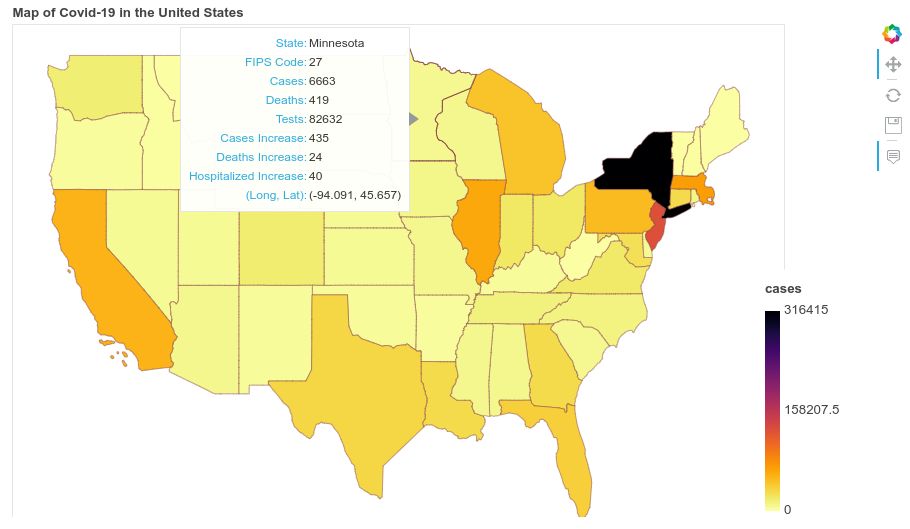

### 3.2 Compare between States
Compare different states
From the previous section, we already know the epidemic data of each state in America. It can be seen that the data gap 
between different states is very large, and what causes this difference? we hope to explore and learn in this section.

In order to simplify this discussion, we use infection cases as an important parameter of the epidemic, but due to 
the large population gap between different states, we use the infection rate as the main indicator, 
infection rate = infection cases / population. In the following figure, We could see the ranking of infection
rates in the US states by the latest date. 



In [18]:
#get the latest date
latest_date = df_daily['date'].max()
#get the data only the latest date
df_daily_l = df_daily[df_daily['date'] == latest_date]
#merge daily vovid19 data with static data
df_merge_d_s = pd.merge(df_daily_l,df_static, how = 'inner',left_on= 'state', right_on='state')
#cal infection rate
df_merge_d_s['infection_rate'] = df_merge_d_s['positive']/df_merge_d_s['population']
df_merge_d_s = df_merge_d_s.set_index('state')

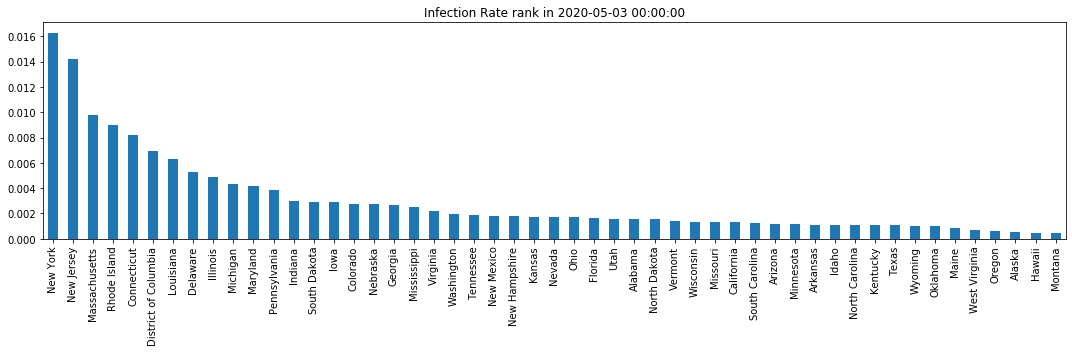

In [19]:
#create diagram  of infection rate rank
fig = plt.figure(figsize=[15,5])
df_fig = df_merge_d_s.sort_values('infection_rate', ascending=False)
df_fig = df_fig['infection_rate']
df_fig.plot(kind='bar', title='Infection Rate rank in '+ str(latest_date), rot=90)
plt.xlabel('')
plt.tight_layout()
plt.show()

We find there are big differences of infection rate between states, which may caused by social, economic, and geographical factors, so we 
selected some relevant attributes and ranked them. See the bar chart diagrams below.

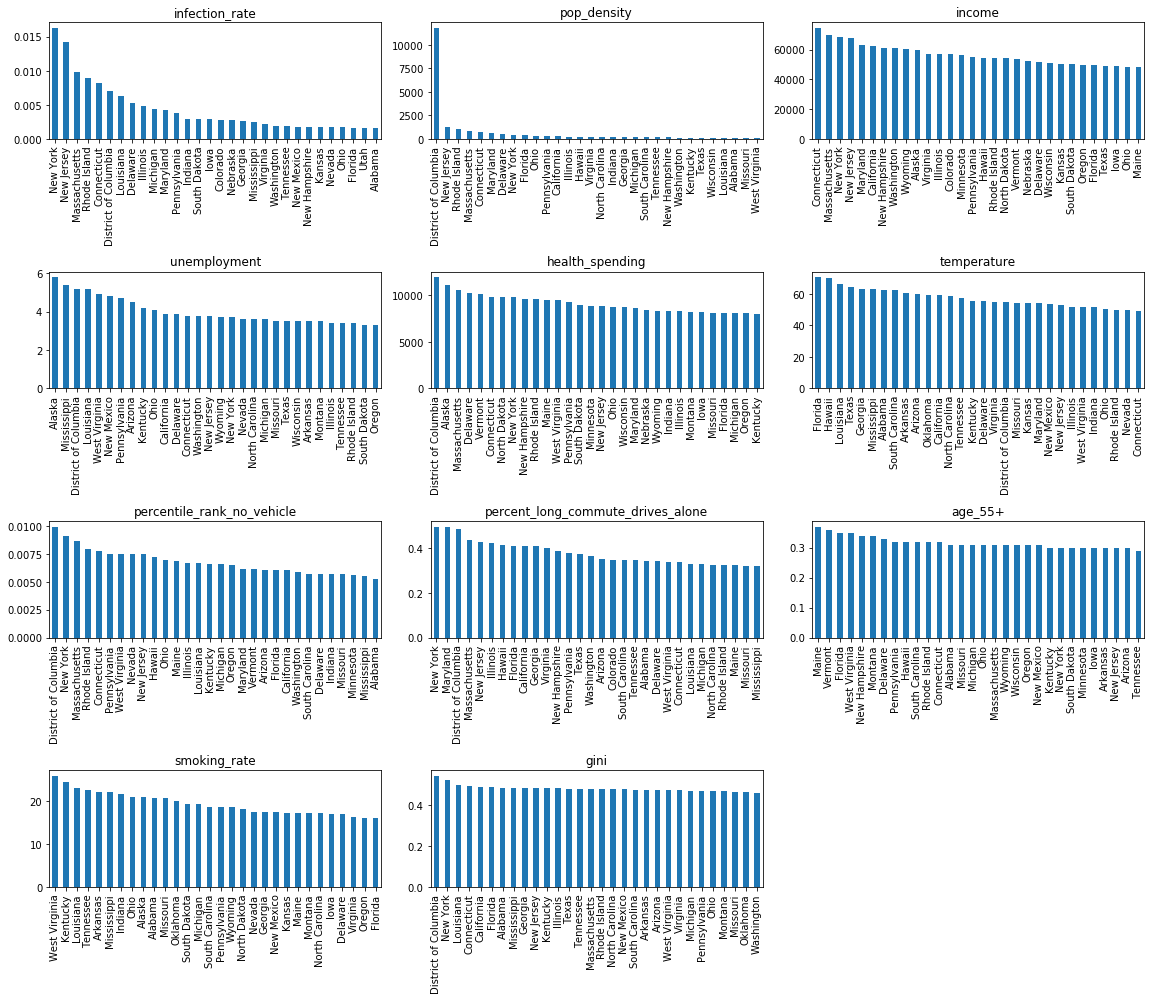

In [20]:
# list(df_merge_d_s.columns.values)
#create bar chart diagrams of relevant factors
indexes = ['infection_rate', 'pop_density', 'income', 'unemployment', 'health_spending', 'temperature', 'percentile_rank_no_vehicle',
'percent_long_commute_drives_alone','age_55+', 'smoking_rate','gini']
x = 1
fig = plt.figure(figsize=[16,14])
for col in indexes:
    df_merged = df_merge_d_s.sort_values(col, ascending=False)
    df_categ = df_merged[col].head(30)
    plt.subplot(4, 3, x)
    df_categ.plot(kind='bar', title=col, rot=90)
    plt.xlabel('')
    plt.tight_layout()
    x += 1
plt.show()

By observing the above bar chart diagrams, we find that population density and infection rate are closely related. For example, New Jersey, Rhode Island 
and Connecticut are in the top 5 of population density rank and also in the top 5 of infection rate rank. However, we also see exceptions, the
population density of District of Columbia is very high, but its infection rate is not high. This may be caused by the its particularity，as it is 
the political center of the United States. So we use boxplot to find these outliers in the data set, see the figure below.

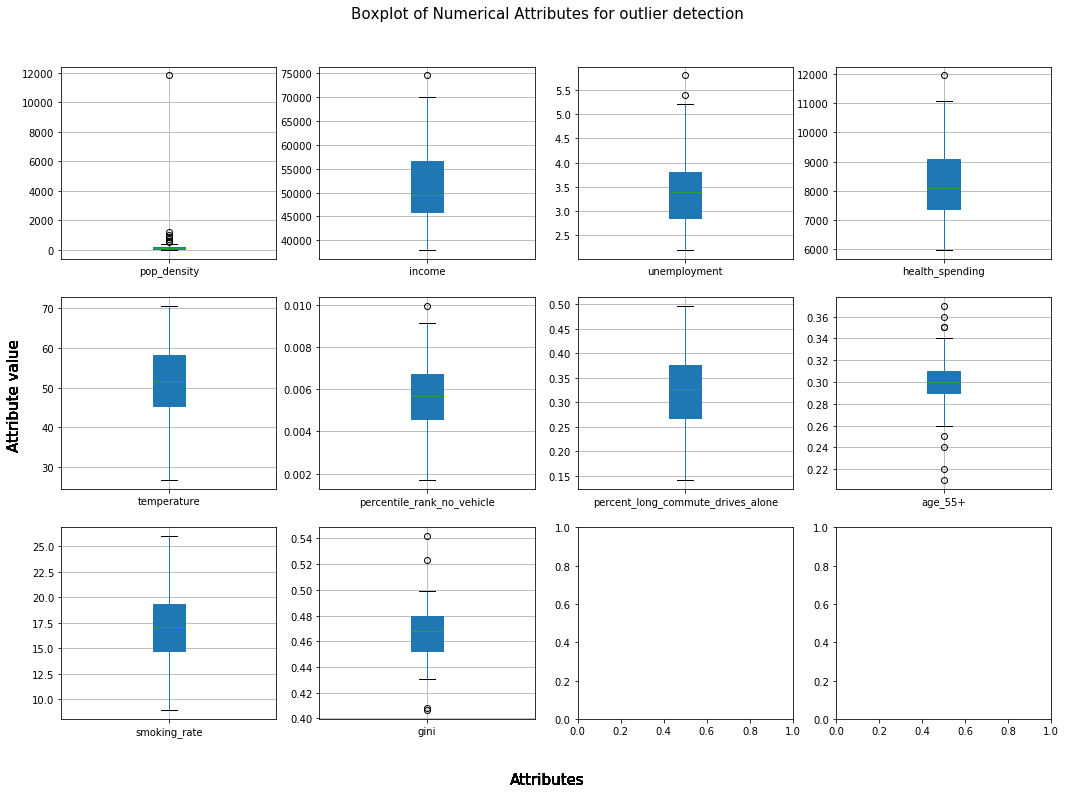

In [21]:
#Selecting columns for outlier detection
indexes = ['pop_density', 'income', 'unemployment', 'health_spending', 'temperature', 'percentile_rank_no_vehicle',
 'percent_long_commute_drives_alone', 'age_55+','smoking_rate','gini']
#Creating a data frame with only the attributes for outlier detection
Outlier = df_merge_d_s[indexes]

fig, axes = plt.subplots(3,4,figsize=(10,12))
for i,el in enumerate(list(Outlier.columns.values)):
    a = Outlier.boxplot(el, patch_artist=True, ax=axes.flatten()[i]) 
    fig.text(0.8, 0.05, 'Attributes', ha='center', fontsize=15)
    fig.text(0.05, 0.5, 'Attribute value', va='center', rotation='vertical', fontsize=15)
plt.subplots_adjust(right=1.5) 
plt.suptitle('Boxplot of Numerical Attributes for outlier detection', x=0.8 , y=0.95, fontsize=15)
plt.show()

Then, we filter out outliers, after it, we plot and do linear fit of each attribute with infection rate. See figure below.

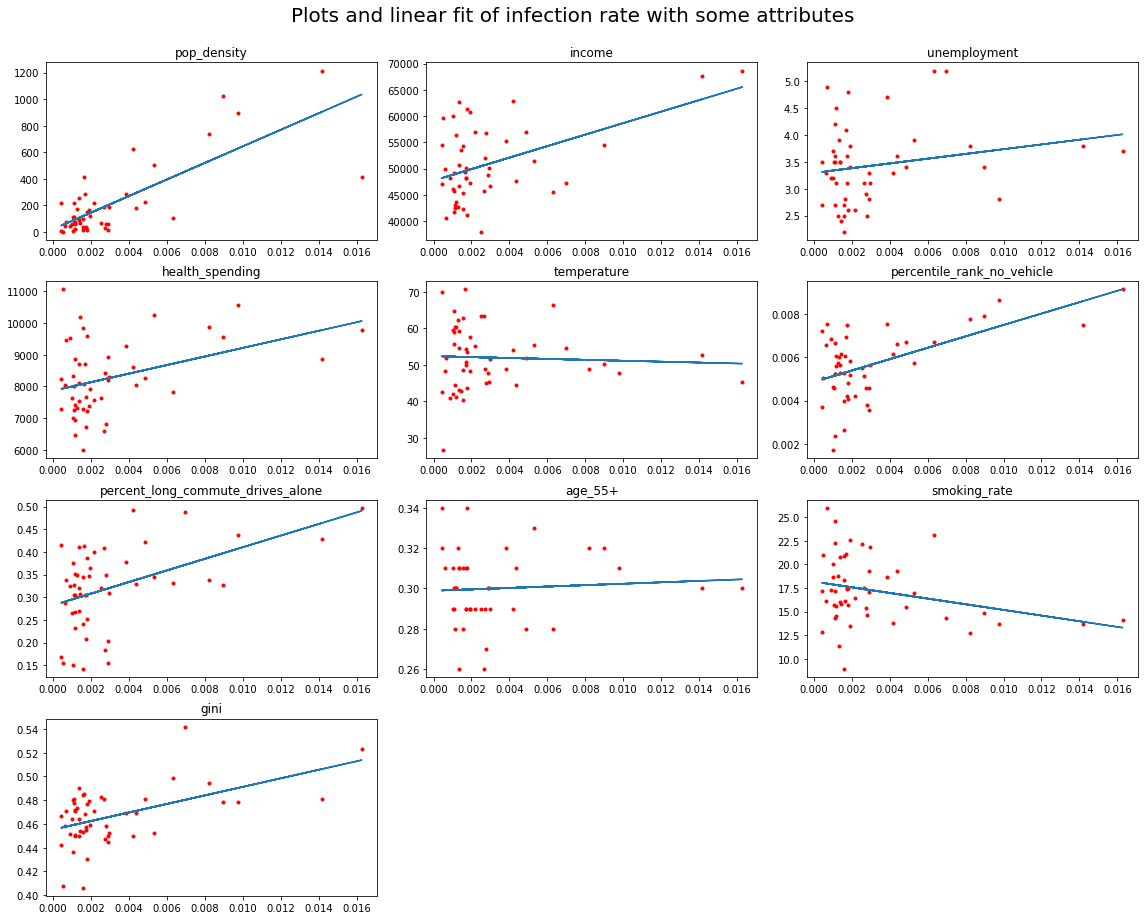

In [22]:
#set indexes
indexes = ['pop_density', 'income', 'unemployment', 'health_spending', 'temperature', 'percentile_rank_no_vehicle',
 'percent_long_commute_drives_alone','age_55+','smoking_rate','gini']
# list(df_merge_d_s.columns.values)

 #create new datset without outlier
df_set = {
    'pop_density' : df_merge_d_s[df_merge_d_s.pop_density < 4000],
    'income' : df_merge_d_s[df_merge_d_s.income <= 70000],
    'unemployment' : df_merge_d_s[df_merge_d_s.unemployment <= 5.2],
    'health_spending' : df_merge_d_s[df_merge_d_s.health_spending <= 11500],
    'temperature' : df_merge_d_s,
    'percentile_rank_no_vehicle' : df_merge_d_s[df_merge_d_s.percentile_rank_no_vehicle <= 0.0096],
    'percent_long_commute_drives_alone' : df_merge_d_s,
    'age_55+' : df_merge_d_s[(df_merge_d_s['age_55+'] <= 0.34) & (df_merge_d_s['age_55+'] >= 0.26)],
    'smoking_rate' : df_merge_d_s,
    'gini' : df_merge_d_s,
    # 'percentile_rank_age_65_and_older' : df_merge_d_s,
} 

#create Plots and linear fit of infection rate with some attributes
x = 1
fig = plt.figure(figsize=[16,13])
for col in indexes:
    df_box_plot = df_set[col]
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(df_box_plot['infection_rate']), np.array(df_box_plot[col])) 

    x1 = np.array(df_box_plot['infection_rate'])
    y1 = np.array(df_box_plot[col])
    line_x = np.array(df_box_plot['infection_rate'])
    line_y = np.array(df_box_plot['infection_rate']) * slope + intercept
    plt.subplot(4, 3, x)
    plt.plot(x1, y1, 'r.')
    plt.title(col)
    plt.plot(line_x, line_y, '-')
    plt.tight_layout()
    fig.subplots_adjust(top=0.92)
    x += 1
fig.suptitle('Plots and linear fit of infection rate with some attributes', fontsize=20)
plt.show()

We find a highly positive correlation between population density and infection rate. Income, health spending, no private vehicle, long commute and 
income inequality (GINI) are also roughly positively correlated with the infection rate. When the infection rate is low this feature is
not very obvious but, when it is high, we could see the values of the attributes exceed the average and are relatively high. 
Smoking rate has negative correlation with infection rate. Also, temperature, age 55+ and unemployment rate has no obvious correlation with the
infection rate, this is not consistent with common sense that the older you are, the greater your chance of infection.
This happens, probably, because it is obscured by other attributes that are more correlated to the infection rate. After all, the infection rate is not determined
by a single factor, but by many factors. We could use association mining to discover the relation between multiple fetures. We check it below.

In [23]:
def binarize(X,Y=None):
    ''' Force binary representation of the matrix, according to X>median(X) '''
    x_was_transposed = False
    if Y is None:
        if X.shape[0] == 1:
            x_was_transposed = True
            X = X.T;
        
        Xmedians = np.ones((np.shape(X)[0],1)) * np.median(X,0)
        Xflags = X>Xmedians
        X[Xflags] = 1; X[~Xflags] = 0

        if x_was_transposed:
            return X.T
        return X
    else:
        return [binarize(X,None),binarize(Y,None)]
        
def binarize2(X,columnnames):
    X = np.concatenate((binarize(X),1-binarize(X)),axis=1)

    new_column_names = []
    [new_column_names.append(elm) for elm in [name+' 50th-100th percentile' for name in columnnames]]
    [new_column_names.append(elm) for elm in [name+' 0th-50th percentile' for name in columnnames]]

    return X, new_column_names

# This is a helper function that transforms a binary matrix into transactions.
# Note the format used for courses.txt was (nearly) in a transaction format,
# however we will need the function later which is why we first transformed
# courses.txt to our standard binary-matrix format.
def mat2transactions(X, labels=[]):
    T = []
    for i in range(X.shape[0]):
        l = np.nonzero(X[i, :])[0].tolist()
        if labels:
            l = [labels[i] for i in l]
        T.append(l)
    return T

# This function print the found rules and also returns a list of rules in the format:
# [(x,y), ...]
# where x -> y
def print_apriori_rules(rules):
    frules = []
    for r in rules:
        for o in r.ordered_statistics:        
            conf = o.confidence
            supp = r.support
            x = ", ".join( list( o.items_base ) )
            y = ", ".join( list( o.items_add ) )
            print("{%s} -> {%s}  (supp: %.3f, conf: %.3f)"%(x,y, supp, conf))
            frules.append( (x,y) )
    return frules
  

# Load  data with index
indexes = ['infection_rate','pop_density', 'income', 'unemployment', 'health_spending', 'temperature', 'percentile_rank_no_vehicle',
 'percent_long_commute_drives_alone','age_55+','smoking_rate','gini']
doc = df_merge_d_s[indexes]

# Extract attribute names (1st row, column 4 to 12)
attributeNames = list(doc.columns.values)

classLabels = list(doc.infection_rate)
classNames = sorted(set(classLabels))
classDict = dict(zip(classNames, range(100)))


# Extract vector y, convert to NumPy array
y = np.asarray([classDict[value] for value in classLabels])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((51, 11))
for i, col_id in enumerate(range(0, 11)):
    X[:, i] = np.asarray(doc.iloc[0:51,col_id])


# We will now transform the wine dataset into a binary format. Notice the changed attribute names:
# from similarity import binarize2
Xbin, attributeNamesBin = binarize2(X, attributeNames)

# calculate the rules with support and confidence
T = mat2transactions(Xbin,labels=attributeNamesBin)
rules = apriori(T, min_support=0.4, min_confidence=0.6)
print_apriori_rules(rules)  

{percent_long_commute_drives_alone 0th-50th percentile} -> {pop_density 0th-50th percentile}  (supp: 0.412, conf: 0.808)
{pop_density 0th-50th percentile} -> {percent_long_commute_drives_alone 0th-50th percentile}  (supp: 0.412, conf: 0.808)


[('percent_long_commute_drives_alone 0th-50th percentile',
  'pop_density 0th-50th percentile'),
 ('pop_density 0th-50th percentile',
  'percent_long_commute_drives_alone 0th-50th percentile')]

See the result above, we find long commute is caused by high pop density, but it doesn't help our goal to find the relation between infection rate 
with multiple factors.  

There are several reasons for not discovering the rule related to the infection rate in association mining. Firstly, our sample is too small  to calculate a reasonable correlation. Secondly,the epidemic is a very complicated incident, which is determined by a combination of many factors, 
and it's difficult to conclude that several factors can determine the infection rate in a state.

Next, we would like to explore the relation between the start time of the epidemic (when positive cases start to appear) in each of the states with the economy, society and geography.

In [24]:
#get all states
states_set = set(df_daily.state)
states = sorted(list(states_set))

#create empty dataframe
df_state_begin = pd.DataFrame(columns=['state', 'start_date'])

#cal start date for each state
for s in states:
    start =  df_daily[(df_daily.state == s) & (df_daily.positive >= 1)]['date'].min()
    df_state_begin = df_state_begin.append([{'state':s,
                                 'start_date':start}], ignore_index=True)

df_state_begin.set_index('state', inplace = True)

#cal Days since first case in each state
begin_min = pd.to_datetime(df_state_begin['start_date'].min())
df_state_begin['day'] =  (pd.to_datetime(df_state_begin['start_date']) - begin_min).dt.days

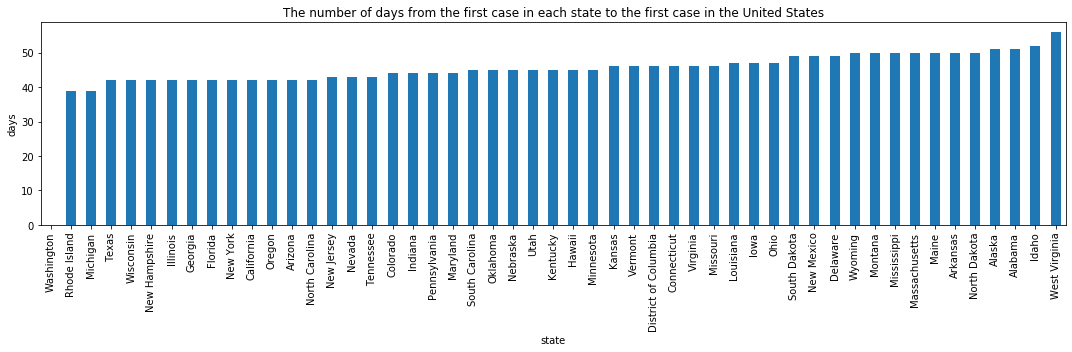

In [25]:
#create bar chart diagram for Days since first case in each state of the United States
fig = plt.figure(figsize=[15,5])
df_fig = df_state_begin.sort_values('day', ascending=True)
df_fig = df_fig['day']
df_fig.plot(kind='bar', title='The number of days from the first case in each state to the first case in the United States', rot=90)
plt.ylabel('days')
plt.tight_layout()
plt.show()

We checked the date of the first case in the United States and we've substracted the date of the first case in each state, plotting the bar chart rank above with the results. With the exception of Washington (where the first case was reported on January 20), the rest of the states started reporting cases 30 days later. Then, we plot and 
do linear fit of each attribute with "the days since first case". See figure below.

In [26]:
#merge dateset
df_merge_begin_s = pd.merge(df_state_begin,df_merge_d_s, how = 'inner',left_on= 'state', right_on='state')

#remove outlier
df_merge_begin_s  = df_merge_begin_s[df_merge_begin_s['day'] > 10]
# df_merge_begin_s['pop_density'].head()

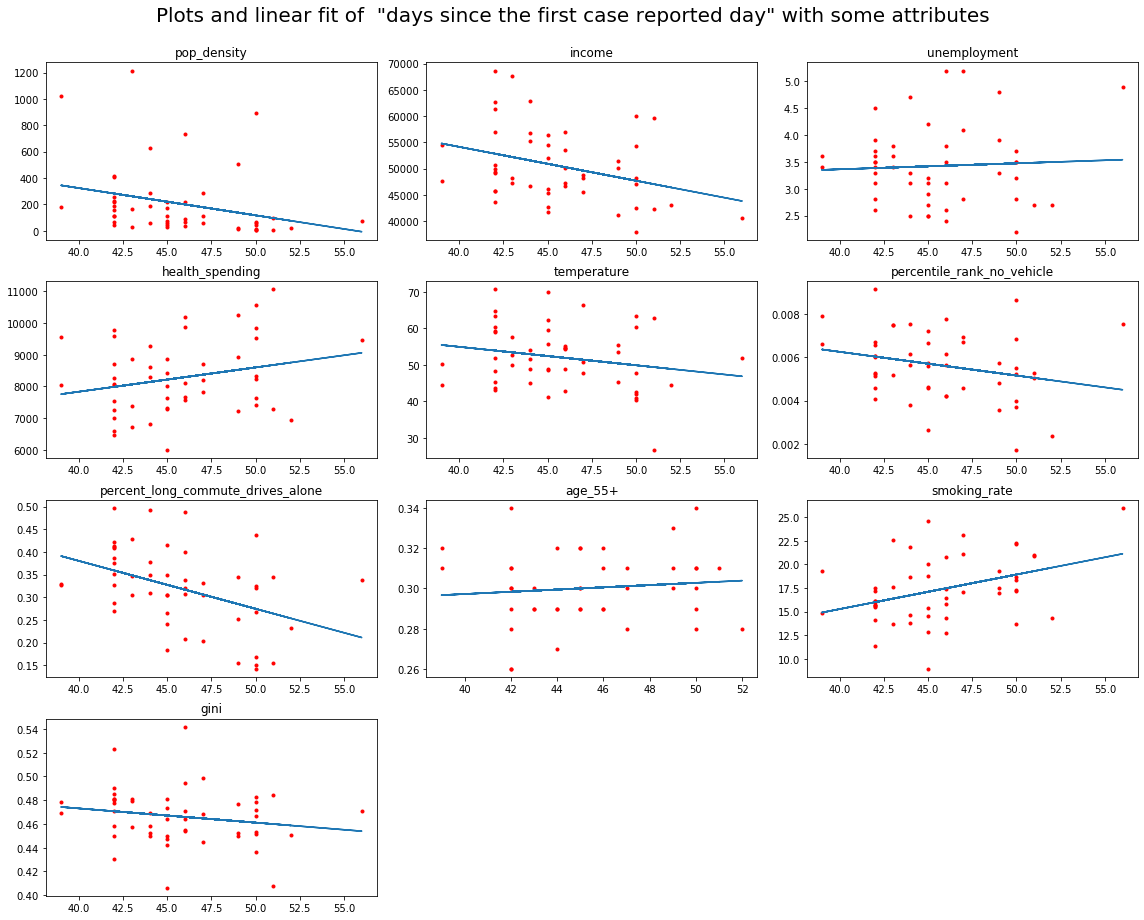

In [27]:
#set indexes
indexes = ['pop_density', 'income', 'unemployment', 'health_spending', 'temperature', 'percentile_rank_no_vehicle',
 'percent_long_commute_drives_alone','age_55+','smoking_rate','gini']

 #create new datset without outlier
df_set = {
    'pop_density' : df_merge_begin_s[df_merge_begin_s.pop_density < 4000],
    'income' : df_merge_begin_s[df_merge_begin_s.income <= 70000],
    'unemployment' : df_merge_begin_s[df_merge_begin_s.unemployment <= 5.2],
    'health_spending' : df_merge_begin_s[df_merge_begin_s.health_spending <= 11500],
    'temperature' : df_merge_begin_s,
    'percentile_rank_no_vehicle' : df_merge_begin_s[df_merge_begin_s.percentile_rank_no_vehicle <= 0.0096],
    'percent_long_commute_drives_alone' : df_merge_begin_s,
    'age_55+' : df_merge_begin_s[(df_merge_begin_s['age_55+'] <= 0.34) & (df_merge_begin_s['age_55+'] >= 0.26)],
    'smoking_rate' : df_merge_begin_s,
    'gini' : df_merge_begin_s,
    # 'percentile_rank_age_65_and_older' : df_merge_begin_s,
} 

#create Plots and linear fit of "days since first case" with some attributes
x = 1
fig = plt.figure(figsize=[16,13])
for col in indexes:
    df_plot = df_set[col]
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(df_plot['day']), np.array(df_plot[col])) 

    x1 = np.array(df_plot['day'])
    y1 = np.array(df_plot[col])
    line_x = np.array(df_plot['day'])
    line_y = np.array(df_plot['day']) * slope + intercept
    plt.subplot(4, 3, x)
    plt.plot(x1, y1, 'r.')
    plt.title(col)
    plt.plot(line_x, line_y, '-')
    plt.tight_layout()
    fig.subplots_adjust(top=0.92)
    x += 1
fig.suptitle('Plots and linear fit of  "days since the first case reported day" with some attributes', fontsize=20)
plt.show()

From the figure above, we can see that high population density, high income, long commute time and no vehicle would cause a lower value for 'days since the first case was reported'. These factors are usually found in densely populated and economically developed states, and it's consistent with 
common sense and the last news on the newspapers.

Now let's compare the infection rate growth curves and other factors of two different states(e.g., New York and Geogia), See figure below.
We find that the slope of the infection rate curve in New York State is greater, 
the infection rate is higher, and its population density and average income value are also greater. Similarly, we can compare other states.

In [28]:
from bokeh.plotting import figure
from bokeh.models import (HoverTool, ColumnDataSource, Panel)
from bokeh.models.widgets import (Div, Select)
from bokeh.layouts import column, row, WidgetBox
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.transform import dodge
import time
import math
from datetime import datetime

output_notebook()
#fill in plot dataset
def make_plot_dataset(state1, state2):

        #fill in data of line1 and line2
    filt_data1 = data[['date',state1]].rename(columns={state1 :'cases'})
    filt_data1['state'] = state1
    filt_data1['date_str'] = filt_data1['date'].dt.strftime('%Y-%m-%d')
    filt_data1['cases_test'] = 100
    new_src2 = ColumnDataSource(filt_data1)
    filt_data2 = data[['date',state2]].rename(columns={state2 :'cases'})
    filt_data2['state'] = state2
    filt_data2['date_str'] = filt_data2['date'].dt.strftime('%Y-%m-%d')
    filt_data2['cases_test'] = 200
    new_src3 = ColumnDataSource(filt_data2)
    src_list = {}
    src_list['src2'] = new_src2
    src_list['src3'] = new_src3
    return src_list


#used in vbar to show multiple bars in proportion    
def change_to_rate(f1, f2):
    if(f1 > f2):
        f1 = f1/f2
        f2 = 1
    else:
        f2 = f2/f1
        f1 = 1
    return [f1,f2]


#fill in hist dataset
def make_bar_chart_dataset(state1, state2):
    #get infection rate data and rank
    infe_rate1 = covid_data2[covid_data2['state'] == state1].iloc[0]['infection_rate']
    infe_rate2 = covid_data2[covid_data2['state'] == state2].iloc[0]['infection_rate']
    [infe_rate1_bar, infe_rate2_bar] = change_to_rate(infe_rate1, infe_rate2)
    covid_data2_sort = covid_data2.sort_values(ascending=False,by="infection_rate")
    covid_data2_sort.reset_index(drop=True, inplace=True)
    infe_rate1_rank = covid_data2_sort[covid_data2_sort['state'] == state1].index.tolist()[0] +1
    infe_rate2_rank = covid_data2_sort[covid_data2_sort['state'] == state2].index.tolist()[0] +1

    #get pop density data and rank
    pop_dens1 = df_static['pop_density'][state1]
    pop_dens2 = df_static['pop_density'][state2]
    [pop_dens1_bar, pop_dens2_bar] = change_to_rate(pop_dens1, pop_dens2)
    pop_dens1 = round(pop_dens1, 4)
    pop_dens2 = round(pop_dens2, 4) 
    state_data_sort = df_static.sort_values(ascending=False,by="pop_density")
    state_data_sort.reset_index(drop=True, inplace=True)
    pop_dens1_rank = state_data_sort[state_data_sort['state'] == state1].index.tolist()[0] +1
    pop_dens2_rank = state_data_sort[state_data_sort['state'] == state2].index.tolist()[0] +1   

    #get income data and rank
    income1 = df_static['income'][state1]
    income2 = df_static['income'][state2]
    [income1_bar, income2_bar] = change_to_rate(income1, income2)
    state_data_sort = df_static.sort_values(ascending=False,by="income")
    state_data_sort.reset_index(drop=True, inplace=True)
    income1_rank = state_data_sort[state_data_sort['state'] == state1].index.tolist()[0] +1
    income2_rank = state_data_sort[state_data_sort['state'] == state2].index.tolist()[0] +1 

    #get Temperature data and rank
    temperature1 = df_static['temperature'][state1]
    temperature2 = df_static['temperature'][state2]
    [temperature1_bar, temperature2_bar] = change_to_rate(temperature1, temperature2)
    state_data_sort = df_static.sort_values(ascending=False,by="temperature")
    state_data_sort.reset_index(drop=True, inplace=True)
    temperature1_rank = state_data_sort[state_data_sort['state'] == state1].index.tolist()[0] +1
    temperature2_rank = state_data_sort[state_data_sort['state'] == state2].index.tolist()[0] +1         

    new_bar_chart_data = {'cates' : cates,
            'state1'   : [infe_rate1, pop_dens1, income1, temperature1],
            'state2'   : [infe_rate2, pop_dens2, income2, temperature2],
            'state1_rank'   : [infe_rate1_rank, pop_dens1_rank, income1_rank, temperature1_rank],
            'state2_rank'   : [infe_rate2_rank, pop_dens2_rank, income2_rank, temperature2_rank],
            'state1_bar'   : [infe_rate1_bar, pop_dens1_bar, income1_bar, temperature1_bar],
            'state2_bar'   : [infe_rate2_bar, pop_dens2_bar, income2_bar, temperature2_bar],                              
            }
    
    bar_chart_source = ColumnDataSource(data=new_bar_chart_data)        

    return bar_chart_source
######################################################################
##
#clear and organize the dataset
## 

#tranlate data and sort
covid_data = df_daily.copy()
covid_data['date'] = pd.to_datetime(covid_data.date, infer_datetime_format=True)
covid_data = covid_data.sort_values(['state','date'])

#use case rate (case/population) as the data to compare
df_static.reset_index(drop='True')
df_static = df_static.set_index('state')
df_static['state'] = df_static.index
df_static.index.name = None
covid_data = pd.merge(covid_data,df_static[['state','population']], how = 'inner',left_on= 'state', right_on='state')
covid_data['infection_rate'] = covid_data['positive']/covid_data['population']


#pivot the table
data = pd.pivot_table(covid_data,index='date',columns='state',values='infection_rate').reset_index()

#covid_data2 only have the latest day covid19 data
covid_data2 = covid_data[covid_data['date'] == covid_data['date'].max()]    
######################################################################

#declare plot dataset
src2 = ColumnDataSource(data=dict(state=[], cases=[], date=[]))
src3 = ColumnDataSource(data=dict(state=[], cases=[], date=[]))

#define sample states
state1 = 'New York'
state2 ='Georgia'

#declare bar chart dataset
cates = ['Infection Rate','Population Density','Income','Temperature']
bar_chart_states = [state1, state2]    
bar_chart_data = {'cates' : cates,
        bar_chart_states[0]   : [2, 1, 4, 3],
        bar_chart_states[1]   : [3, 2, 4, 4],
        'state1_rank'   : [2, 1, 4, 3],
        'state2_rank'   : [2, 1, 4, 3],}
bar_chart_source = ColumnDataSource(data=bar_chart_data)


#prepare plot dataset
src_set = make_plot_dataset(state1, state2)
src2 = src_set['src2']
src3 = src_set['src3']
#prepare bar_chart data
bar_chart_source = make_bar_chart_dataset(state1, state2)



######################################################################

##draw plots 
hover_tool = HoverTool(tooltips=[
        # ('Cases', '@cases_test'),
        ('Infection Rates', '@cases{0.000000}'),
        ('Date', '@date_str')],
        # formatters={'date': 'datetime'}
    )

p1 = figure(plot_width=400,plot_height=300,x_axis_type='datetime',
        tools=[hover_tool],title='Comparison graph of infection cases rates growth(Cases/Pop)')
p1.line(x='date',y='cases', source=src2, legend_label= state1, line_color='#c9d9d3',
        line_width=3,line_alpha=.8, hover_line_alpha=1.0)
p1.line(x='date',y='cases', source=src3, legend_label = state2, line_color='#718dbf',
        line_width=3,line_alpha=.8, hover_line_alpha=1.0)

p1.background_fill_color = "whitesmoke"
p1.background_fill_alpha = 0.5
p1.legend.location = "top_left"
p1.xaxis.axis_label = 'Date'
p1.yaxis.axis_label = 'Infection Rate'
p1.xaxis.formatter=DatetimeTickFormatter(days='%m-%d')  
p1.yaxis.formatter.use_scientific = False  

##draw vbars for compare two states' infection cases, population density, health spending, etc.
bar_chart_hover_tool = HoverTool(tooltips=[
        ('State1 Value', '@state1{0.0000}'),
        ('State2 Value', '@state2{0.0000}'),
        ('State1 Rank', '@state1_rank{int}'),
        ('State2 Rank', '@state2_rank{int}'),
        ],
    )
p2 = figure(x_range=cates, plot_height=300, title="Bar chart comparison between states by " + str(covid_data['date'].max().strftime('%Y-%m-%d')) ,
        toolbar_location=None, tools=[bar_chart_hover_tool])

p2.vbar(x=dodge('cates', -0.25, range=p2.x_range), top= 'state1_bar', width=0.2, source=bar_chart_source, 
                color="#c9d9d3", legend_label= state1,  fill_alpha = 1,  )
p2.vbar(x=dodge('cates',  0.0,  range=p2.x_range), top= 'state2_bar', width=0.2, source=bar_chart_source,
                color="#718dbf", legend_label= state2,  fill_alpha = 1 )

p2.x_range.range_padding = 0.1
p2.xgrid.grid_line_color = None
p2.legend.location = "top_right"
p2.legend.orientation = "horizontal"

plots = row(p1, p2)
show(plots)

Loading BokehJS ...

### 3.3 Prediction of unemployment using COVID data
In the preliminary data analysis, we have seen that the unemployment data we have is way too outdated compared to the COVID dataset. Since the recent rise of unemployment is certainly an effect of the COVID-19, it would make sense to predict the unemployment for the remaining days using COVID data. To create predictions, we merge the daily COVID and unemployment datasets.

In [29]:
# Match the rows of the two datasets by state and date, and merge them 
df_model = df_daily.merge(df_unemploy, on=['state', 'date'])

# Remove date as it's useless for training

del df_model['date']
df_model.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,unemployment
0,Alaska,257.0,7475.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,...,7732.0,7732.0,7732.0,2,1.0,3.0,289.0,11.0,300.0,11.48
1,Alabama,3191.0,18058.0,0.0,0.0,402.0,0.0,0.0,0.0,0.0,...,21249.0,21249.0,21249.0,1,11.0,34.0,0.0,223.0,223.0,4.94
2,Arkansas,1226.0,17352.0,0.0,86.0,130.0,0.0,43.0,33.0,39.0,...,18578.0,18578.0,18578.0,5,1.0,0.0,1403.0,55.0,1458.0,5.56
3,Arizona,3393.0,37137.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40530.0,40530.0,40530.0,4,11.0,0.0,2515.0,281.0,2796.0,4.21
4,California,19472.0,152604.0,13200.0,5236.0,0.0,1591.0,0.0,0.0,0.0,...,185276.0,172076.0,172076.0,6,68.0,0.0,7213.0,0.0,7213.0,8.25


If we inspect the correlations between the columns, we can see that there is indeed a notable correlation between unemployment and COVID-variables like the number of positives.

In [30]:
df_model.corr()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,unemployment
positive,1.000000,0.779674,0.038334,0.970033,0.925869,0.922243,0.006747,0.253562,-0.005563,0.897622,...,0.881815,0.892429,0.892429,0.013693,0.981718,0.816692,0.468021,0.928289,0.651039,0.333942
negative,0.779674,1.000000,0.090009,0.718225,0.647984,0.674511,0.118250,0.224502,0.021356,0.599917,...,0.972626,0.978331,0.978331,0.041304,0.720677,0.600246,0.652827,0.745730,0.749959,0.514947
pending,0.038334,0.090009,1.000000,0.068959,-0.010060,0.118733,-0.012698,-0.012593,-0.008460,-0.009221,...,0.199786,0.077530,0.077530,-0.129850,0.020484,-0.011807,0.074665,0.057234,0.077694,0.026468
hospitalizedCurrently,0.970033,0.718225,0.068959,1.000000,0.897654,0.948298,-0.020514,0.306921,-0.012961,0.863675,...,0.832348,0.838245,0.838245,0.010865,0.960138,0.825284,0.432504,0.918615,0.619136,0.290596
hospitalizedCumulative,0.925869,0.647984,-0.010060,0.897654,1.000000,0.893829,0.032108,-0.015397,0.001048,0.973539,...,0.758490,0.773031,0.773031,0.028256,0.931310,0.870154,0.373913,0.836012,0.547313,0.198216
inIcuCurrently,0.922243,0.674511,0.118733,0.948298,0.893829,1.000000,-0.012433,0.285301,-0.012168,0.873207,...,0.792014,0.790946,0.790946,0.002866,0.928227,0.801966,0.404276,0.831008,0.570763,0.250899
inIcuCumulative,0.006747,0.118250,-0.012698,-0.020514,0.032108,-0.012433,1.000000,-0.018622,0.231608,-0.004115,...,0.084361,0.087434,0.087434,0.087472,0.004423,0.034259,0.047852,-0.001020,0.038934,0.247465
onVentilatorCurrently,0.253562,0.224502,-0.012593,0.306921,-0.015397,0.285301,-0.018622,1.000000,-0.004543,-0.005630,...,0.239820,0.245601,0.245601,-0.014201,0.243768,-0.018752,0.114557,0.216371,0.156230,0.279315
onVentilatorCumulative,-0.005563,0.021356,-0.008460,-0.012961,0.001048,-0.012168,0.231608,-0.004543,1.000000,-0.004944,...,0.012270,0.013548,0.013548,0.037905,-0.010614,0.003352,0.015960,-0.005151,0.011600,0.031268
recovered,0.897622,0.599917,-0.009221,0.863675,0.973539,0.873207,-0.004115,-0.005630,-0.004944,1.000000,...,0.715376,0.729057,0.729057,0.033350,0.909644,0.771030,0.328759,0.759248,0.488187,0.190720


First, we need to figure out which dates we are missing from the unemployment dataset, in other words, for which dates we should predict the unemployment.

In [31]:
# Get every occurring date from the COVID dataset
covid_dataset_dates = set(df_daily['date'].unique())

# Get every occurring date from the unemployment dataset
unemployment_dataset_dates = set(df_unemploy['date'].unique())

# Find out which dates are missing from the unemployment dataset
missing_dates = covid_dataset_dates - unemployment_dataset_dates

missing_dates

{numpy.datetime64('2020-04-12T00:00:00.000000000'),
 numpy.datetime64('2020-04-13T00:00:00.000000000'),
 numpy.datetime64('2020-04-14T00:00:00.000000000'),
 numpy.datetime64('2020-04-15T00:00:00.000000000'),
 numpy.datetime64('2020-04-16T00:00:00.000000000'),
 numpy.datetime64('2020-04-17T00:00:00.000000000'),
 numpy.datetime64('2020-04-18T00:00:00.000000000'),
 numpy.datetime64('2020-04-19T00:00:00.000000000'),
 numpy.datetime64('2020-04-20T00:00:00.000000000'),
 numpy.datetime64('2020-04-21T00:00:00.000000000'),
 numpy.datetime64('2020-04-22T00:00:00.000000000'),
 numpy.datetime64('2020-04-23T00:00:00.000000000'),
 numpy.datetime64('2020-04-24T00:00:00.000000000'),
 numpy.datetime64('2020-04-25T00:00:00.000000000'),
 numpy.datetime64('2020-04-26T00:00:00.000000000'),
 numpy.datetime64('2020-04-27T00:00:00.000000000'),
 numpy.datetime64('2020-04-28T00:00:00.000000000'),
 numpy.datetime64('2020-04-29T00:00:00.000000000'),
 numpy.datetime64('2020-04-30T00:00:00.000000000'),
 numpy.datet

####  Train model based on the number of positives
As a first try, we fit a linear regression model on each state-specific subset of the data, based on the number of positive tests.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

linear_models_based_on_positives = dict()
model_accuracies_based_on_positives = dict()

# Fit a linear model to data belonging to each state, so one line for Alabama, one for Arizona, etc...
for state in states:

    # Get records that belong to the particular state
    df_model_state = df_model[df_model['state'] == state]
    
    # Set the unemployment column as target variable "y"
    y = df_model_state['unemployment'].to_numpy()
    del df_model_state['unemployment'], df_model_state['state']
    
    # Set the cases column of the dataframe as features "X"
    X = df_model_state['positive'].to_numpy().reshape((-1, 1))

    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # Use linear regression with ridge regularization for idk why
    l = Ridge(alpha=100)
    l.fit(X_train, y_train)
    score = l.score(X_test, y_test)
    
    # Save the linear model into the dict of linear models
    linear_models_based_on_positives[state] = l
    
    # Save the score just for debugging
    model_accuracies_based_on_positives[state] = score

model_accuracies_based_on_positives

{'Alabama': 0.9845041215892263,
 'Alaska': 0.8967209411285182,
 'Arizona': 0.9694623680746801,
 'Arkansas': 0.9399970788166173,
 'California': 0.9872615933653879,
 'Colorado': 0.7468192748529722,
 'Connecticut': 0.9364826843028388,
 'Delaware': 0.909695763513879,
 'District of Columbia': 0.9658349412150256,
 'Florida': 0.7532043685864624,
 'Georgia': 0.9936396833906584,
 'Hawaii': 0.9770606063344198,
 'Idaho': 0.9950224631513708,
 'Illinois': 0.9653428967216464,
 'Indiana': 0.979168243167911,
 'Iowa': 0.9771889486713353,
 'Kansas': 0.9933440291204167,
 'Kentucky': 0.9101910135108319,
 'Louisiana': 0.9814305756573146,
 'Maine': 0.9871660060431279,
 'Maryland': 0.9773549373181591,
 'Massachusetts': 0.883580477748297,
 'Michigan': 0.700669533887224,
 'Minnesota': 0.9939052944999903,
 'Mississippi': 0.9056892451906989,
 'Missouri': 0.9907683251125587,
 'Montana': 0.9761884407792948,
 'Nebraska': 0.9721332221756958,
 'Nevada': 0.9969618640982347,
 'New Hampshire': 0.9768176678640916,
 'New 

The scores of model fitting seem promising. Now we can predict the unemployment for the remaining dates.

In [33]:
def predict_unemployment(row, linear_models):
    # For a given row in the dataset
    
    # create feature x out of cases
    X = np.array([row['positive']]).reshape(1, -1)
    
    # Find the name of the state the row belongs to
    state = row['state']
    
    # Predict y (unemployment) by plugging feature x to the linear model of the state
    return linear_models[state].predict(X)[0]
    
# Apply the above function to each of the rows to predict unemployment
df_for_pred = df_daily[df_daily['date'].isin(list(missing_dates))]
df_for_pred['unemployment_positives'] = df_for_pred.apply(lambda row: predict_unemployment(row, linear_models_based_on_positives), axis=1)
df_for_pred.head()

/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,unemployment_positives
0,2020-05-03,Alaska,368.0,21210.0,0.0,12.0,0.0,0.0,0.0,0.0,...,21578.0,21578.0,21578.0,2,0.0,0.0,176.0,3.0,179.0,13.258262
1,2020-05-03,Alabama,7725.0,84775.0,0.0,0.0,1035.0,0.0,403.0,0.0,...,92500.0,92500.0,92500.0,1,2.0,12.0,0.0,291.0,291.0,10.925162
2,2020-05-03,Arkansas,3431.0,49459.0,0.0,100.0,427.0,0.0,0.0,20.0,...,52890.0,52890.0,52890.0,5,3.0,13.0,1249.0,59.0,1308.0,12.260890
4,2020-05-03,Arizona,8640.0,72479.0,0.0,732.0,1348.0,282.0,0.0,192.0,...,81119.0,81119.0,81119.0,4,14.0,9.0,2846.0,276.0,3122.0,8.751218
5,2020-05-03,California,53616.0,662135.0,0.0,4734.0,0.0,1468.0,0.0,0.0,...,715751.0,715751.0,715751.0,6,44.0,0.0,27529.0,1419.0,28948.0,19.146496


#### Train a model based on the number of positives and deaths
Now we try to build a bit more complex model. We apply linear regression on each state-specific subset of the data, based on the number of positive tests and deaths.

In [34]:
linear_models_based_on_positives_and_deaths = dict()
model_accuracies_based_on_positives_and_deaths = dict()

# Fit a linear model to data belonging to each state, so one line for Alabama, one for Arizona, etc...
for state in states:
    
    # Get records that belong to the particular state
    df_model_state = df_model[df_model['state'] == state]
    
    # Set the unemployment column as target variable "y"
    y = df_model_state['unemployment'].to_numpy()
    del df_model_state['unemployment'], df_model_state['state']
    
    # Set the rest of dataframe as features "X"
    X = df_model_state[['positive', 'death']].to_numpy()

    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # Use linear regression with ridge regularization for idk why
    l = Ridge(alpha=100)
    l.fit(X_train, y_train)
    score = l.score(X_test, y_test)
    
    # Save the linear model into the dict of linear models
    linear_models_based_on_positives_and_deaths[state] = l
    
    # Save the score just for debugging
    model_accuracies_based_on_positives_and_deaths[state] = score
model_accuracies_based_on_positives_and_deaths

{'Alabama': 0.9942865752251168,
 'Alaska': 0.9219009594677767,
 'Arizona': 0.9989941336446677,
 'Arkansas': 0.9215520957170953,
 'California': 0.9752953384895658,
 'Colorado': 0.9711700116773305,
 'Connecticut': 0.982209129862149,
 'Delaware': 0.915216095172413,
 'District of Columbia': 0.9133619135151363,
 'Florida': 0.9787828379063951,
 'Georgia': 0.9933372053154974,
 'Hawaii': 0.9356006896907759,
 'Idaho': 0.9853904389626397,
 'Illinois': 0.9847798125578996,
 'Indiana': 0.9973854994212535,
 'Iowa': 0.9879824547305478,
 'Kansas': 0.9623126421756715,
 'Kentucky': 0.9111937494431094,
 'Louisiana': 0.9855093525719716,
 'Maine': 0.990371870732968,
 'Maryland': 0.988536217782937,
 'Massachusetts': 0.9768056687423312,
 'Michigan': 0.993735175353052,
 'Minnesota': 0.9928701388335507,
 'Mississippi': 0.982311183142875,
 'Missouri': 0.9980515260091422,
 'Montana': 0.9811350736285178,
 'Nebraska': 0.9719207919017252,
 'Nevada': 0.9963630706626708,
 'New Hampshire': 0.9876901911497044,
 'New Je

We proceed to predict the missing unemployment with this model as well.

In [35]:
def predict_unemployment(row, linear_models):
    # For a given row in the dataset
    
    # create feature vector x out of cases and deaths
    X = np.array([row['positive'], row['death']]).reshape(1, -1)
    
    # Find the name of the state the row belongs to
    state = row['state']
    
    # Predict y (unemployment) by plugging feature vector x to the linear model of the state
    return linear_models[state].predict(X)[0]
    
# Apply the above function to each of the rows to predict unemployment
df_for_pred['unemployment_positives_deaths'] = df_for_pred.apply(
    lambda row: predict_unemployment(row, linear_models_based_on_positives_and_deaths), axis=1)
df_for_pred.head()

/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,unemployment_positives,unemployment_positives_deaths
0,2020-05-03,Alaska,368.0,21210.0,0.0,12.0,0.0,0.0,0.0,0.0,...,21578.0,21578.0,2,0.0,0.0,176.0,3.0,179.0,13.258262,12.567278
1,2020-05-03,Alabama,7725.0,84775.0,0.0,0.0,1035.0,0.0,403.0,0.0,...,92500.0,92500.0,1,2.0,12.0,0.0,291.0,291.0,10.925162,13.075821
2,2020-05-03,Arkansas,3431.0,49459.0,0.0,100.0,427.0,0.0,0.0,20.0,...,52890.0,52890.0,5,3.0,13.0,1249.0,59.0,1308.0,12.260890,13.649625
4,2020-05-03,Arizona,8640.0,72479.0,0.0,732.0,1348.0,282.0,0.0,192.0,...,81119.0,81119.0,4,14.0,9.0,2846.0,276.0,3122.0,8.751218,12.445698
5,2020-05-03,California,53616.0,662135.0,0.0,4734.0,0.0,1468.0,0.0,0.0,...,715751.0,715751.0,6,44.0,0.0,27529.0,1419.0,28948.0,19.146496,20.722904


#### Prediction of unemployment by fitting a single model on the dataset
So far, we have fitted models to state-specific subsets of the date. It might make sense to fit a single model on the whole dataset. We are aware of the fact that the relation between COVID-19 and the unemployment may differ from state to state, therefore we try to apply one-hot encode the state names and feed it into our models. Apart from them, we continue using the number of positives and deaths as features.

In [36]:
df_model = pd.get_dummies(df_model[['state', 'positive', 'death', 'unemployment']], columns=['state'])
df_model.head()

,positive,death,unemployment,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,257.0,8.0,11.48,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3191.0,91.0,4.94,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1226.0,24.0,5.56,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3393.0,108.0,4.21,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19472.0,609.0,8.25,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


We set our feature matrix and target vector...

In [37]:
# Set the unemployment column as target variable
y = df_model['unemployment'].to_numpy()
del df_model['unemployment']

# Set the rest of data as features
X = df_model.to_numpy()

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

First, we fit a linear regression on the data.

In [38]:
from sklearn.linear_model import LinearRegression
# Could also be Ridge() or some other regularized regression

l = LinearRegression()
l.fit(X_train, y_train)
l.score(X_test, y_test)

0.23812320798649245

The fitting doesn't seem to be good... It makes sense, since there may be no linear relation between the one-hot encoded state information and the unemployment.

As an alternative, we try to fit a decision tree regressor on the dataset.

In [39]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.score(X_test, y_test)

0.9575853279120083

The goodness of fit is much better, seems promising!

Now we use these models to actually predict the unemployment.

In [40]:
# Create a feature dataset for prediction
df_for_pred_missing_dates = df_daily[df_daily['date'].isin(list(missing_dates))]

# Limit this dataset to the selected features
df_for_pred_missing_dates = df_for_pred_missing_dates[['state', 'positive', 'death']]

# Do one-hot encoding
df_for_pred_single_model = pd.get_dummies(df_for_pred_missing_dates, columns=['state'])

# Create the feature array out of the dataframe
X = df_for_pred_single_model.to_numpy()

# Predict using the linear regression
y_linreg = l.predict(X)

# Predict using the decision tree regressor
y_dtr = dtr.predict(X)

# Append the predicted data to the other two predictions
df_for_pred['unemployment_linreg'] = y_linreg
df_for_pred['unemployment_dtr'] = y_dtr
df_for_pred.head()

/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,unemployment_positives,unemployment_positives_deaths,unemployment_linreg,unemployment_dtr
0,2020-05-03,Alaska,368.0,21210.0,0.0,12.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,176.0,3.0,179.0,13.258262,12.567278,5.174443,11.480000
1,2020-05-03,Alabama,7725.0,84775.0,0.0,0.0,1035.0,0.0,403.0,0.0,...,1,2.0,12.0,0.0,291.0,291.0,10.925162,13.075821,2.645563,4.908571
2,2020-05-03,Arkansas,3431.0,49459.0,0.0,100.0,427.0,0.0,0.0,20.0,...,5,3.0,13.0,1249.0,59.0,1308.0,12.260890,13.649625,2.509494,4.721429
4,2020-05-03,Arizona,8640.0,72479.0,0.0,732.0,1348.0,282.0,0.0,192.0,...,4,14.0,9.0,2846.0,276.0,3122.0,8.751218,12.445698,2.338884,10.518571
5,2020-05-03,California,53616.0,662135.0,0.0,4734.0,0.0,1468.0,0.0,0.0,...,6,44.0,0.0,27529.0,1419.0,28948.0,19.146496,20.722904,9.200240,10.130000


Now as we have the predictions of our four models, we merge our data back into the original unemployment data.

In [41]:
# Create a copy of the unemployment dataset that is going to be appended with the predictions
df_unemploy_complete = df_unemploy.copy()

# Pre-populate the columns of the various predictions
df_unemploy_complete['unemployment_positives'] = df_unemploy_complete['unemployment']
df_unemploy_complete['unemployment_positives_deaths'] = df_unemploy_complete['unemployment']
df_unemploy_complete['unemployment_linreg'] = df_unemploy_complete['unemployment']
df_unemploy_complete['unemployment_dtr'] = df_unemploy_complete['unemployment']

# Remove the original unemployment column
del df_unemploy_complete['unemployment']

# Append the predicted unemployment values to the existing unemployment data
df_unemploy_complete = df_unemploy_complete.append(df_for_pred[['date', 'state', 'unemployment_positives', 'unemployment_positives_deaths', 'unemployment_linreg', 'unemployment_dtr']])
df_unemploy_complete = df_unemploy_complete.sort_values('date')
df_unemploy_complete

,date,state,unemployment_positives,unemployment_positives_deaths,unemployment_linreg,unemployment_dtr
0,2020-01-04,Alabama,0.960000,0.960000,0.960000,0.960000
28,2020-01-04,Nevada,1.530000,1.530000,1.530000,1.530000
29,2020-01-04,New Hampshire,0.680000,0.680000,0.680000,0.680000
30,2020-01-04,New Jersey,2.780000,2.780000,2.780000,2.780000
31,2020-01-04,New Mexico,1.270000,1.270000,1.270000,1.270000
...,...,...,...,...,...,...
30,2020-05-03,North Carolina,24.046358,22.333482,3.851030,11.082857
29,2020-05-03,Montana,12.507019,12.596517,5.615967,11.730000
28,2020-05-03,Mississippi,13.965354,16.658665,2.285698,5.367143
25,2020-05-03,Minnesota,51.627085,47.870737,6.034583,10.968571


In [42]:
# Save the predictions for plotting
df_unemploy_complete.to_csv('unemployment_predicted_data.csv', index=False)

#### Visualization of the results
As the final step, we visualize our results using Bokeh, in the same way as it is presented on the website. First, we begin with reshaping our data so that it would have states as columns and dates as rows.

In [43]:
df_unemploy_plotting = pd.DataFrame(pd.pivot_table(df_unemploy_complete, values='unemployment_positives', index='date', columns='state', aggfunc='sum', fill_value=0))
df_unemploy_plotting['date'] = df_unemploy_plotting.index
df_unemploy_plotting['date'] = pd.to_datetime(df_unemploy_plotting['date'])
df_unemploy_plotting = df_unemploy_plotting.reset_index(drop=True)
df_unemploy_plotting.head()

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,date
0,0.96,3.320000,0.630000,1.280000,2.090000,0.81,2.810000,1.560000,1.250000,0.420000,...,0.680000,1.160000,0.780000,1.790000,0.600000,2.120000,2.370000,1.740000,1.200000,2020-01-04
1,0.98,3.278571,0.631429,1.282857,2.085714,0.81,2.818571,1.565714,1.247143,0.418571,...,0.681429,1.158571,0.784286,1.798571,0.604286,2.118571,2.415714,1.758571,1.204286,2020-01-05
2,1.00,3.237143,0.632857,1.285714,2.081429,0.81,2.827143,1.571429,1.244286,0.417143,...,0.682857,1.157143,0.788571,1.807143,0.608571,2.117143,2.461429,1.777143,1.208571,2020-01-06
3,1.02,3.195714,0.634286,1.288571,2.077143,0.81,2.835714,1.577143,1.241429,0.415714,...,0.684286,1.155714,0.792857,1.815714,0.612857,2.115714,2.507143,1.795714,1.212857,2020-01-07
4,1.04,3.154286,0.635714,1.291429,2.072857,0.81,2.844286,1.582857,1.238571,0.414286,...,0.685714,1.154286,0.797143,1.824286,0.617143,2.114286,2.552857,1.814286,1.217143,2020-01-08


Next, we proceed with the plotting.

In [44]:
from bokeh.plotting import show, figure, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Legend, Span
from bokeh.models import BoxZoomTool, ResetTool, LassoSelectTool, WheelZoomTool
from bokeh.palettes import Category20b as palette
import itertools

output_notebook()

# Create our color iterator for giving each line a different color
colors = itertools.cycle(palette[20])

# Collect the state names to filter data by the state-specific columns.
state_names = np.unique(df_unemploy_complete['state'].to_numpy())

# Create the column data source based on the prepared dataframe
source = ColumnDataSource(df_unemploy_plotting)

# Set the figure dimensions, title, tooltips and tooltip formatting
title = 'Unemployment prediction'
plot_width = 1000
plot_height = 600
tooltips = [
    ('State', '$name'),
    ('Date', '$x{%d %b}'),
    ('Unemployment', '$y{%0.2f%%}')
]
formatters = {
    '$x': 'datetime',
    '$y': 'printf'
}

# Create the hover tool, given the tooltip and formatting data
hovertool = HoverTool(tooltips=tooltips,
          formatters=formatters)

# Finally, build the figure
p = figure(
    title=title,
    plot_width=plot_width,
    plot_height=plot_height,
    x_axis_type='datetime',
    tools=[hovertool, BoxZoomTool(), ResetTool(), LassoSelectTool(), WheelZoomTool()],
    toolbar_location='below'
)

# Preallocate a list for the legend tuples
legendTuples = []

# For each state, create a line plot of unemployment-date points
for state_name in state_names:
    plot = p.line(
        x='date', 
        y=state_name,
        name=state_name,
        line_width=3,
        source=source,
        color=next(colors)
    )
    legendTuples.append((state_name, [plot]))
    
# Create the vertical line dividing the existing and projected data
prediction_from_date = pd.to_datetime('2020-04-11')
span = Span(location=prediction_from_date, dimension='height', line_color='red', line_width=2, line_dash='dashed')
p.renderers.extend([span])
    
# Create the multi-column legend, as glorious Bokeh does not support it out of the box...
legendColumns = 5
for i in range(legendColumns):
    legendCol = Legend(
        items=legendTuples[i::legendColumns],
        location=(130*i, plot_height-430)
    )
    p.add_layout(legendCol)

# Add axis labels
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Unemployment [%]'

show(p)

Loading BokehJS ...

In case the plot would not render... A screenshot of the plot can be found below.

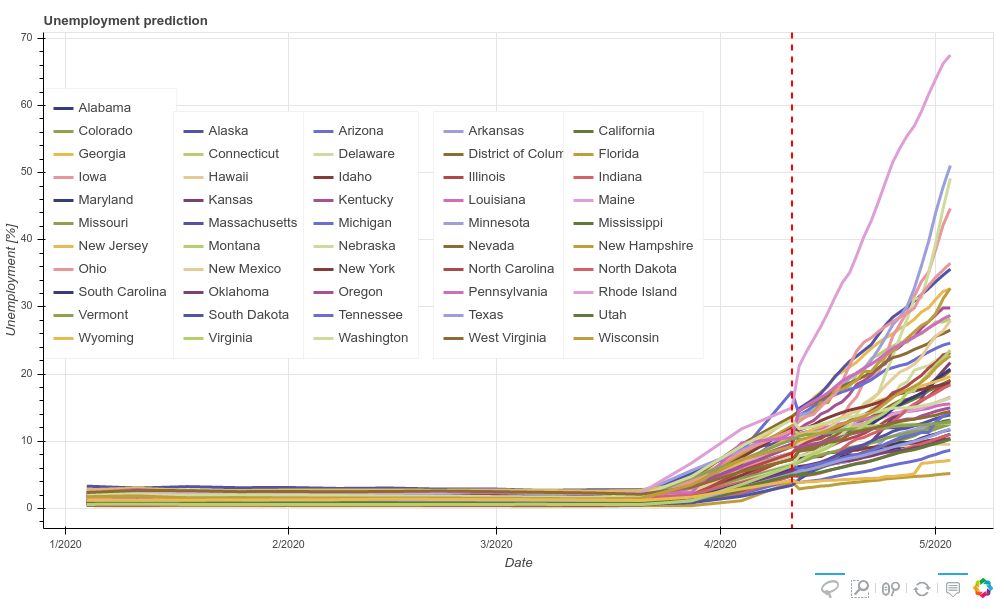

### Prediction of hospitalizations
It also makes sense to predict the number of hospitalized people based on other COVID-related factors, such as the number of positive tests and deaths.

#### Prediction of hospitalizations based on the number of positive, negative and all tests, recoveries and deaths
We begin with training linear models on each state-specific subset of the COVID data, based on the features mentioned above.

In [45]:
linear_models_pnrdt = dict()
model_accuracies_pnrdt = dict()

from datetime import datetime

# Fit a linear model to data belonging to each state, so one line for Alabama, one for Arizona, etc...
for state in df_daily.state.unique():
    
    # Get records that belong to the particular state
    df_model_state = df_daily[df_daily['state'] == state]
    
    # Remove last dates (the ones we're going to predict)
    df_model_state = df_model_state[df_model_state['date'] < datetime(2020, 4, 21)]
    
    # Set the unemployment column as target variable "y"
    y = df_model_state['hospitalizedCurrently'].to_numpy()
    df_model_state.drop(df_model_state.columns.difference(['positive','negative','recovered','death', 'total']),
                        1, inplace=True)
    
    # Set the rest of dataframe as features "X"
    X = df_model_state.to_numpy()

    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # Use linear regression with ridge regularization for idk why
    l = Ridge(alpha=100)
    l.fit(X_train, y_train)
    score = l.score(X_test, y_test)
    
    # Save the linear model into the dict of linear models
    linear_models_pnrdt[state] = l
    
    # Save the score just for debugging
    model_accuracies_pnrdt[state] = score
model_accuracies_pnrdt

{'Alaska': 0.7648857051040843,
 'Alabama': 1.0,
 'Arkansas': 0.9673080482442294,
 'Arizona': 0.6560508850235331,
 'California': 0.8897242276943036,
 'Colorado': 0.983615207512654,
 'Connecticut': 0.9796436724229229,
 'District of Columbia': 0.8531447161208859,
 'Delaware': 0.9963241430435564,
 'Florida': 1.0,
 'Georgia': 1.0,
 'Hawaii': 1.0,
 'Iowa': 0.982569361607358,
 'Idaho': 1.0,
 'Illinois': 0.8240798364893938,
 'Indiana': 1.0,
 'Kansas': 1.0,
 'Kentucky': 0.8356330870265823,
 'Louisiana': 0.9852760257125037,
 'Massachusetts': 0.8662225340073418,
 'Maryland': 1.0,
 'Maine': 0.777765390538109,
 'Michigan': 0.8076852588861787,
 'Minnesota': 0.9885823426779382,
 'Missouri': 0.7389072361273196,
 'Mississippi': 0.0,
 'Montana': 0.7274387416161816,
 'North Carolina': 0.9217012312952104,
 'North Dakota': 0.7745478250048282,
 'Nebraska': 1.0,
 'New Hampshire': 0.8755522314073101,
 'New Jersey': 0.9435027012582934,
 'New Mexico': 0.9656281720100769,
 'Nevada': -0.07911999411090065,
 'New Y

Next, we prepare a dataset to put our predicted values into.

In [46]:
# Prepare the part of COVID dataset that does not have associated hospitalization data yet
df_for_pred = df_daily[df_daily['date'] > datetime(2020, 4, 20)]
df_for_pred

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-05-03,Alaska,368.0,21210.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,21578.0,21578.0,21578.0,2,0.0,0.0,176.0,3.0,179.0
1,2020-05-03,Alabama,7725.0,84775.0,0.0,0.0,1035.0,0.0,403.0,0.0,...,1035.0,92500.0,92500.0,92500.0,1,2.0,12.0,0.0,291.0,291.0
2,2020-05-03,Arkansas,3431.0,49459.0,0.0,100.0,427.0,0.0,0.0,20.0,...,427.0,52890.0,52890.0,52890.0,5,3.0,13.0,1249.0,59.0,1308.0
4,2020-05-03,Arizona,8640.0,72479.0,0.0,732.0,1348.0,282.0,0.0,192.0,...,1348.0,81119.0,81119.0,81119.0,4,14.0,9.0,2846.0,276.0,3122.0
5,2020-05-03,California,53616.0,662135.0,0.0,4734.0,0.0,1468.0,0.0,0.0,...,0.0,715751.0,715751.0,715751.0,6,44.0,0.0,27529.0,1419.0,28948.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2020-04-21,Vermont,818.0,12293.0,0.0,41.0,0.0,0.0,0.0,0.0,...,0.0,13111.0,13111.0,13111.0,50,2.0,0.0,128.0,2.0,130.0
724,2020-04-21,Washington,12550.0,151017.0,0.0,503.0,0.0,161.0,0.0,0.0,...,0.0,163567.0,163567.0,163567.0,53,11.0,0.0,4598.0,204.0,4802.0
725,2020-04-21,Wisconsin,4620.0,47841.0,219.0,358.0,1252.0,137.0,324.0,0.0,...,1252.0,52680.0,52461.0,52461.0,55,12.0,41.0,1238.0,121.0,1359.0
726,2020-04-21,West Virginia,914.0,21849.0,0.0,85.0,0.0,42.0,0.0,24.0,...,0.0,22763.0,22763.0,22763.0,54,2.0,0.0,596.0,12.0,608.0


Now we can predict the number of hospitalizations, and assign the results to the dataframe created above.

In [47]:
def predict_hospitalized(row, linear_models):
    # For a given row in the dataset
    
    # create feature vector x out of our variables
    X = np.array([row['positive'], row['negative'], row['recovered'], row['death'], row['total']]).reshape(1, -1)

    # Find the name of the state the row belongs to
    state = row['state']
    
    # Predict y (hospitalized) by plugging feature vector x to the linear model of the state
    return linear_models[state].predict(X)[0]
    
# Apply the above function to each of the rows to predict hospitalized
df_for_pred['hospitalized_pnrdt'] = df_for_pred.apply(lambda row: predict_hospitalized(row, linear_models_pnrdt), axis=1)
df_for_pred

/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hospitalized_pnrdt
0,2020-05-03,Alaska,368.0,21210.0,0.0,12.0,0.0,0.0,0.0,0.0,...,21578.0,21578.0,21578.0,2,0.0,0.0,176.0,3.0,179.0,170.184243
1,2020-05-03,Alabama,7725.0,84775.0,0.0,0.0,1035.0,0.0,403.0,0.0,...,92500.0,92500.0,92500.0,1,2.0,12.0,0.0,291.0,291.0,0.000000
2,2020-05-03,Arkansas,3431.0,49459.0,0.0,100.0,427.0,0.0,0.0,20.0,...,52890.0,52890.0,52890.0,5,3.0,13.0,1249.0,59.0,1308.0,60.754142
4,2020-05-03,Arizona,8640.0,72479.0,0.0,732.0,1348.0,282.0,0.0,192.0,...,81119.0,81119.0,81119.0,4,14.0,9.0,2846.0,276.0,3122.0,1455.401736
5,2020-05-03,California,53616.0,662135.0,0.0,4734.0,0.0,1468.0,0.0,0.0,...,715751.0,715751.0,715751.0,6,44.0,0.0,27529.0,1419.0,28948.0,6672.812892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2020-04-21,Vermont,818.0,12293.0,0.0,41.0,0.0,0.0,0.0,0.0,...,13111.0,13111.0,13111.0,50,2.0,0.0,128.0,2.0,130.0,34.448021
724,2020-04-21,Washington,12550.0,151017.0,0.0,503.0,0.0,161.0,0.0,0.0,...,163567.0,163567.0,163567.0,53,11.0,0.0,4598.0,204.0,4802.0,758.084217
725,2020-04-21,Wisconsin,4620.0,47841.0,219.0,358.0,1252.0,137.0,324.0,0.0,...,52680.0,52461.0,52461.0,55,12.0,41.0,1238.0,121.0,1359.0,442.038702
726,2020-04-21,West Virginia,914.0,21849.0,0.0,85.0,0.0,42.0,0.0,24.0,...,22763.0,22763.0,22763.0,54,2.0,0.0,596.0,12.0,608.0,120.638184


#### Prediction of hospitalizations based on positive tests and deaths
We train another set of linear models on each state-specific subset of the COVID data, based on the number of positive tests and deaths.

In [48]:
linear_models_pd = dict()
model_accuracies_pd = dict()

# Fit a linear model to data belonging to each state, so one line for Alabama, one for Arizona, etc...
for state in df_daily.state.unique():
    
    # Get records that belong to the particular state
    df_model_state = df_daily[df_daily['state'] == state]
    
    # Remove last dates (the ones we're going to predict)
    df_model_state = df_model_state[df_model_state['date'] < datetime(2020, 4, 21)]
    
    # Set the unemployment column as target variable "y"
    y = df_model_state['hospitalizedCurrently'].to_numpy()
    df_model_state.drop(df_model_state.columns.difference(['positive','death']),
                        1, inplace=True)
    
    # Set the rest of dataframe as features "X"
    X = df_model_state.to_numpy()

    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # Use linear regression with ridge regularization for idk why
    l = Ridge(alpha=100)
    l.fit(X_train, y_train)
    score = l.score(X_test, y_test)
    
    # Save the linear model into the dict of linear models
    linear_models_pd[state] = l
    
    # Save the score just for debugging
    model_accuracies_pd[state] = score
model_accuracies_pd

{'Alaska': 0.0,
 'Alabama': 1.0,
 'Arkansas': 0.8452784369111922,
 'Arizona': 0.795320860750577,
 'California': 0.8792345590524473,
 'Colorado': 0.9812343987512981,
 'Connecticut': 0.982089540542365,
 'District of Columbia': 0.7789979937057351,
 'Delaware': 0.9573465181275925,
 'Florida': 1.0,
 'Georgia': 1.0,
 'Hawaii': 1.0,
 'Iowa': 0.9455038414159797,
 'Idaho': 1.0,
 'Illinois': 0.8000776729224954,
 'Indiana': 1.0,
 'Kansas': 1.0,
 'Kentucky': -0.17142458754812506,
 'Louisiana': 0.9059509675029134,
 'Massachusetts': 0.9308749177854564,
 'Maryland': 1.0,
 'Maine': 0.7318631346012618,
 'Michigan': 0.7392917442987257,
 'Minnesota': 0.9886809378373044,
 'Missouri': 0.9208255796442466,
 'Mississippi': 0.0,
 'Montana': 0.5774856223464017,
 'North Carolina': 0.9526149725549635,
 'North Dakota': 0.6808337977559297,
 'Nebraska': 1.0,
 'New Hampshire': 0.0,
 'New Jersey': 0.9601492716156055,
 'New Mexico': 0.9939016148216506,
 'Nevada': -0.9455459463287127,
 'New York': 0.9738735942524034,
 '

As we have trained our models, we can predict hospitalizations.

In [49]:
def predict_hospitalized(row, linear_models):
    # For a given row in the dataset
    
    # create feature vector x out of our variables
    X = np.array([row['positive'], row['death']]).reshape(1, -1)
    
    # Find the name of the state the row belongs to
    state = row['state']
    
    # Predict y (hospitalized) by plugging feature vector x to the linear model of the state
    return linear_models[state].predict(X)[0]
    
# Apply the above function to each of the rows to predict hospitalized
df_for_pred['hospitalized_pd'] = df_for_pred.apply(lambda row: predict_hospitalized(row, linear_models_pd), axis=1)
df_for_pred

/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hospitalized_pnrdt,hospitalized_pd
0,2020-05-03,Alaska,368.0,21210.0,0.0,12.0,0.0,0.0,0.0,0.0,...,21578.0,21578.0,2,0.0,0.0,176.0,3.0,179.0,170.184243,16.249259
1,2020-05-03,Alabama,7725.0,84775.0,0.0,0.0,1035.0,0.0,403.0,0.0,...,92500.0,92500.0,1,2.0,12.0,0.0,291.0,291.0,0.000000,0.000000
2,2020-05-03,Arkansas,3431.0,49459.0,0.0,100.0,427.0,0.0,0.0,20.0,...,52890.0,52890.0,5,3.0,13.0,1249.0,59.0,1308.0,60.754142,189.063957
4,2020-05-03,Arizona,8640.0,72479.0,0.0,732.0,1348.0,282.0,0.0,192.0,...,81119.0,81119.0,4,14.0,9.0,2846.0,276.0,3122.0,1455.401736,1492.098606
5,2020-05-03,California,53616.0,662135.0,0.0,4734.0,0.0,1468.0,0.0,0.0,...,715751.0,715751.0,6,44.0,0.0,27529.0,1419.0,28948.0,6672.812892,8597.228924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2020-04-21,Vermont,818.0,12293.0,0.0,41.0,0.0,0.0,0.0,0.0,...,13111.0,13111.0,50,2.0,0.0,128.0,2.0,130.0,34.448021,52.709221
724,2020-04-21,Washington,12550.0,151017.0,0.0,503.0,0.0,161.0,0.0,0.0,...,163567.0,163567.0,53,11.0,0.0,4598.0,204.0,4802.0,758.084217,627.378234
725,2020-04-21,Wisconsin,4620.0,47841.0,219.0,358.0,1252.0,137.0,324.0,0.0,...,52461.0,52461.0,55,12.0,41.0,1238.0,121.0,1359.0,442.038702,476.579327
726,2020-04-21,West Virginia,914.0,21849.0,0.0,85.0,0.0,42.0,0.0,24.0,...,22763.0,22763.0,54,2.0,0.0,596.0,12.0,608.0,120.638184,89.507389


As we have our two predictions, we can merge them into the already existing hospitalization data.

In [50]:
# Create the dataset that contains the existing and predicted hospitalization data
df_hospital_existing = df_daily[df_daily['date'] < datetime(2020, 4, 21)]

df_hospital_existing['hospitalized_pnrdt'] = df_hospital_existing['hospitalizedCurrently']
df_hospital_existing['hospitalized_pd'] = df_hospital_existing['hospitalizedCurrently']

column_selection = ['date', 'state', 'hospitalized_pnrdt', 'hospitalized_pd']

df_hospital_existing = df_hospital_existing[column_selection]

# Merge the predictions into the existing hospitalization data
df_hospital_complete = df_hospital_existing.append(df_for_pred[column_selection])
df_hospital_complete = df_hospital_complete.sort_values('date')

# There is no such a thing as 3.14 people
df_hospital_complete = df_hospital_complete.round({'hospitalized_pnrdt': 0, 'hospitalized_pd': 0})

df_hospital_complete

/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,state,hospitalized_pnrdt,hospitalized_pd
3320,2020-01-22,Washington,0.0,0.0
3319,2020-01-23,Washington,0.0,0.0
3318,2020-01-24,Washington,0.0,0.0
3317,2020-01-25,Washington,0.0,0.0
3316,2020-01-26,Washington,0.0,0.0
...,...,...,...,...
31,2020-05-03,North Dakota,50.0,46.0
30,2020-05-03,North Carolina,593.0,498.0
29,2020-05-03,Montana,16.0,14.0
26,2020-05-03,Missouri,1729.0,1739.0


#### Plotting of results
We can now proceed with plotting the results. For brevity, we are going to plot the data predicted by the model that was based on the number of positives and deaths. In order to plot our data, we reshape our dataset in a way that its columns correspond to the states and the rows correspond to dates.

In [51]:
df_hospital_complete_piv = pd.DataFrame(pd.pivot_table(df_hospital_complete, values='hospitalized_pd', index='date', columns='state', aggfunc='sum', fill_value=0))
df_hospital_complete_piv['date'] = df_hospital_complete_piv.index
df_hospital_complete_piv['date'] = pd.to_datetime(df_hospital_complete_piv['date'])
df_hospital_complete_piv = df_hospital_complete_piv.reset_index(drop=True)
df_hospital_complete_piv

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,date
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-01-22
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-01-23
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-01-24
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-01-25
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-01-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0,15,1273,207,7485,891,2116,413,1018,0,...,0,2457,0,55,3049,851,109,543,16,2020-04-29
99,0,15,1319,209,7880,871,2166,401,1135,0,...,0,2502,0,55,3223,869,112,541,17,2020-04-30
100,0,16,1337,208,8097,976,2257,413,1142,0,...,0,2601,0,56,3378,883,114,538,17,2020-05-01
101,0,16,1418,190,8353,925,2257,406,1193,0,...,0,2731,0,56,3597,888,118,532,17,2020-05-02


With our data in the right form, we can proceed with the actual plotting.

In [52]:
output_notebook()

# Create a color iterator to give each of the lines a different color
colors = itertools.cycle(palette[20])

# Create an array of state names for later indexing
state_names = np.unique(df_hospital_complete['state'].to_numpy())

# Build a column data source from the prepared dataset
source = ColumnDataSource(df_hospital_complete_piv)

# Set up the properties of the Bokeh figure object - title, dimensions, tooltips, tooltip formatting
title = 'Hospitalization prediction'
plot_width = 1000
plot_height = 600
tooltips = [
    ('State', '$name'),
    ('Date', '$x{%d %b}'),
    ('Hospitalizations', '$y')
]
formatters = {
    '$x': 'datetime'
}

# Create the mouse hover tool given the tooltip and tooltip formatting information
hovertool = HoverTool(tooltips=tooltips,
          formatters=formatters)

# Create the actual figure
p = figure(
    title=title,
    plot_width=plot_width,
    plot_height=plot_height,
    x_axis_type='datetime',
    tools=[hovertool, BoxZoomTool(), ResetTool(), LassoSelectTool(), WheelZoomTool()],
    toolbar_location='below'
)

# Create an array of legend tuples
legendTuples = []

# For each state, create a line plot of hospitalizations-date points
for state_name in state_names:
    plot = p.line(
        x='date', 
        y=state_name,
        name=state_name,
        line_width=3,
        source=source,
        color=next(colors)
    )
    legendTuples.append((state_name, [plot]))
    
# Create the vertical line dividing the existing and projected data
prediction_from_date = pd.to_datetime('2020-04-20')
span = Span(location=prediction_from_date, dimension='height', line_color='red', line_width=2, line_dash='dashed')
p.renderers.extend([span])

# Create the multi-column legend, as glorious Bokeh does not support it out of the box... 
legendColumns = 4
for i in range(legendColumns):
    legendCol = Legend(
        items=legendTuples[i::legendColumns],
        location=(130*i, plot_height-420)
    )
    p.add_layout(legendCol)

# Add axis labels
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Hospitalizations [1]'

show(p)

Loading BokehJS ...

In case the plot would not render... A screenshot of the plot can be found below.

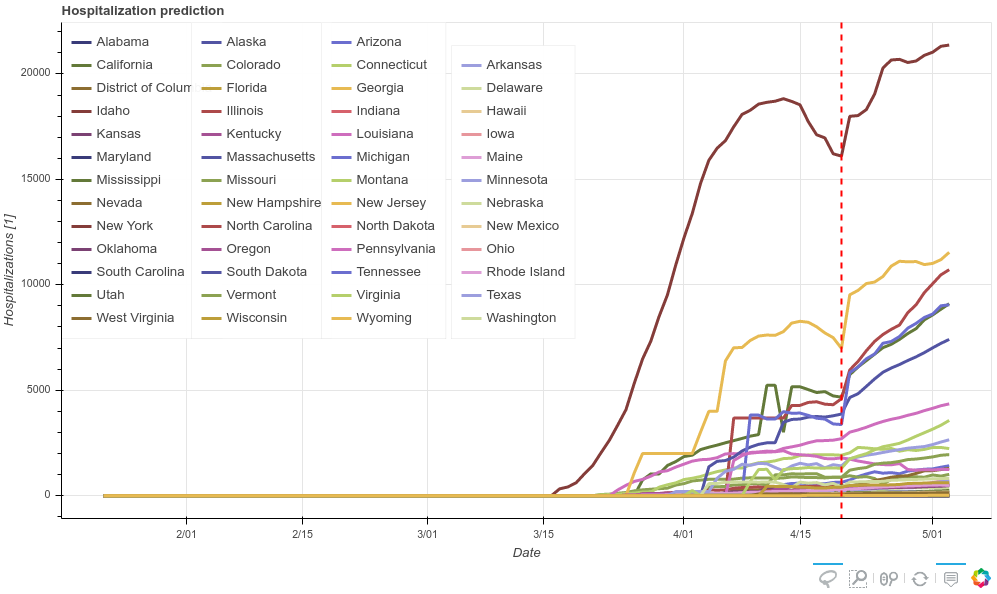

## 4. Genre

### 4.1 Which genre of data story did you use?

The genres we used for our data story are annotated graphs (including the COVID-19 map for the US) and partitioned poster (due to the structure of some tabs, like the 'Comparison between states' one).

### 4.2 Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer paper). Why?

- **Covid19 Map in United States**

We used Consistent Visual Platform and Progress Bar from the visual structuring category. Users can see consistent data of cases, deaths and other data type in each US state. 
The color of states on the map intuitively shows the number of one data type (such as cases) in the states, and data type can be chosen by user. 
Meanwhile, user can drag the date slider and see that the data changes in all the states over time. <br><br>
We used Close-Ups and Feature Distinction from the highlighting category. When user hover over a state on the map, the state will be highlighted 
and there will be text explaining the details of the state. The colors of the states on the map are clearly distinguished according to the amount 
of data in that state. <br><br>
From the map, we hope that users can intuitively know the epidemic situation in various states of the United States, and can compare between states.
Also, through the date slider, user can know how the spread of the epidemic in the United States.

- **Comparison between States**

We used Consistent Visual Platform from the visual structuring category. User can see the infection rate growth curve for the two selected 
states. <br><br>
We used Close-Ups and Feature Distinction from the highlighting category. When user hover over a point on the growth curve of infection rate or hover 
over the bar graph, there will be text explaining the details. The height of the data for the two states in the bar graph shows the difference between 
them.<br><br>
We used these methods to compare the infection rate growth curve between the two states, and try to explore what factors determine the difference
between each other.

- **Correlation between COVID-19 mortality and socioeconomic factors**
  
We used Feature Distinction from the highlighting category. The length of the data for the factors in the bar chart diagram shows the different 
correlation with covid19 mortality. This is very easy for users to know correlations and compare between different factors.

- **Unemployment forecast & Hospitalization forecast**

We used Consistent Visual Platform from the visual structuring category. User can see the whole forcast unemployment rate curve and
hospitalization rate curve 
in each state for the selected prediction model, and user can well find the trend of unemployment rate. 

We used  Feature Distinction from the highlighting category. The forecast curve of each state is represented by a color, and user 
can distinguish one from others easily.




### 4.3 Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

- **Covid19 Map in United States**
  
We used the user directed path from the category ordering. The user can select the date and data type to view the content he is interested in,
  and it is better for user to do comparison(the epidemic in same state, but different date or epidemic in different states, different data types 
  etc.). 

We used Hover Highlighting, Selection and Stimulating Default Views from the category interactivity. After loading the page, the map is rendered by 
infection cases excit the users to have the desire to learn and explore the data on the map. The details that appears on the
 map when hovered satisfies the user ’s need for learning, and the selection bar satisfies the user ’s need to explore. 

 We used Captions/Headlines and Introductory Text from the category messaging. At the sidebar of the page there is a brief description of the
 this page and how to explore it. Also, there is a headline above the map.

- **Comparison beteen States**
  
We used the user directed path from the category ordering. The user can select the two different states he is interested in,
and it is very clear for user to do comparison between states. 

We used Hover Highlighting, Selection and Stimulating Default Views from the category interactivity. After loading the page, the graphs rendered by 
comparison between New York and Geogia excit the users to have the desire to learn and explore dfference of the data between states. The details that appears 
on the graphs when hovered satisfies the user ’s need for learning and comparing, and the selection bar satisfies the user ’s need to explore. <br><br>
We used Captions/Headlines and Introductory Text from the category messaging. At the sidebar of the page there is a brief description of the
this page and how to explore it. Also, there is a headline above each graph.


- **Correlation between COVID-19 mortality and socioeconomic factors**
  
We used Hover Highlighting and Stimulating Default Views from the category interactivity. After loading the page, the graphs rendered by 
showing all the correlation of factors excit the users explore the details. The details that appears on the graphs when hovered satisfies 
the user ’s need for learning and comparing. 

We used Captions/Headlines and Introductory Text from the category messaging. At the top of the page there is a brief description of the
this page and how to explore it. Also, there is a headline above the graph.

- **Unemployment forecast & Hospitalization forecast**
  
We used the user directed path from the category ordering. The user can select the prediction model he is interested in,
and it is very clear for user to do comparison between states. 

We used Selection and Stimulating Default Views from the category interactivity. After loading the page, the graphs rendered by 
one default predction model excit the users to have the desire to learn and explore dfference of the data between states. The selection bar 
satisfies the user ’s need to explore. 

We used Captions/Headlines and Introductory Text from the category messaging. At the top of the page there is a brief description of the
this page and how to explore it. Also, there is a headline above each graph.  

## 5. Visualizations

### 5.1 Explain the visualizations you've chosen and  Why are they right for the story you want to tell?
First, we have chosen the United States map to provide a visual overview of the Coronavirus impact in the states. 
As we mentioned before, one of the most interesting facts is that the virus is not affecting in the same way to all the states, 
so we wanted to show it over time and country's geography in a simple and intuitive way. <br><br>
Second, the map is not the best way to check a big amount of statistics. So we added the second tab 'Comparison between states' 
in order to provide a proper tool to check these details if someone wants to know more about 
the growth of the virus (upper plot) and the socioeconomic factors (lower plot) for each of the states. 
We added the possibility to compare them in pairs, just to let the user check this big difference between some states 
and link it to their different socioeconomic factors. <br><br>
For the third tab, after been exposing the details and let the user compare then, 
we wanted to demonstrate this strong relation virus impact vs. socioeconomic factors in one single plot. 
To achieve this, we plotted the biggest correlations between the mortality of the COVID-19 and the socioeconomic factors of our dataset. 
<br><br>
Finally, we worked on some predictions based on the information we have about the virus. Its huge impact is obvious if we look to the number 
of cases and deaths, but the consecuences of the virus could be even more dramatic at the end. 
That's why we chose to predict the unemployment rate for each state in a single plot, where the user can check with the cursor which line 
corresponds with each of the states. The same plot is used to show our prediction of the number of hospitalized people per state. 
Both of them have an option box above to switch between the different prediction models to check how the predictions change.

## 6. Discussion

### 6.1 What went well?
In general terms we are satisfied about the final result of the project. From the beginning we knew the visualizations 
were going to be interesting for the user, because we have a lot of posibilities with the datasets and it's trending topic nowadays. 
The interactive map is very useful to provide a quick overview (we were agree about this one since the first moment) and the user 
can get a good idea of how is the impact of the virus in the United States after taking a look to the website. 
The plots are easy to understand and the different tabs help to provide a good summary of the situation, 
achieving the main aim of the project just telling a story in a proper order.
### 6.2 What is still missing? What could be improved? Why?
Although there is a lot of data related with this topic (specially for the US), 
it's still very soon to find good quality datasets sometimes and we are missing very interesting information that could help to explain 
the behavior of the virus within the states. For example, we have not been able to find information about the flights during March and April 
or some concrete data about the public transport or people movility for the same dates 
(in some states like New York this can be very interesting). <br><br>
In part because of that we had faced problems with the machine-learning part, but it's realistic to say that 
it would be necessary to find a lot of data and work long hours to get some good predictions for the unemployment 
and the number of hospitalized people (something that it's out of the scope for the time we have for this project). 
This problem was mentioned in class when we were watching the videos some weeks ago and we had a lot of doubts 
when choosing the idea for the project because of it. In conclusion, the predictions can be improved easily with more data 
and more work time but we wanted to provide some results with the models we tried with. <br><br>
We could also have tried to predict other parameters related with the virus, but we didn't manage to find better ideas 
with our datasets and what we found online.

## 7. Contributions

All of us have been actively contributing to progress with this project, but of course we have been distributing the tasks 
to manage properly with the time and discussing every week which steps to take. This notebook has been made thanks to the colaboration 
of the three of us. Some concrete details about the contributions of each group member are listed below:
<ul>
    <li><strong>Miklós</strong> has worked a lot with the data analysis, looking for strong correlations within the data. 
    Then, he took care of the unemployment prediction, trying with different models to improve the final result. 
    He made the plots for both prediction tabs in the webpage, but also the correlation plot for the socioeconomic factors 
    of the third tab.</li>
    <li><strong>Carlos</strong> did most of the data research online trying to find interesting and good quality datasets. 
    After that, he put some effort to build and clean the project datasets. He also worked to get a first version of the COVID-19 map and 
    add more options to its option box. Finally, he worked on the number of hospitalized people's prediction and did some formatting 
    work for website.
    </li>
    <li><strong>Li</strong> started working with Bokeh to create the first version of the website. Then, he worked to build the COVID-19 map tab
    (60% contribution), 
    in addition to that, he did a lot of data analysis to do comparison between two states and built state-comparison tab.
    Next, he did the "3.1 Covid19 map of United States","3.2 Compare between States" and "4. Genre" part of this notebook. 
    Finally, he deployed the website in alibabacloud.</li>
</ul>

## 8. References
[1] Bokeh.  [https://bokeh.org/](https://bokeh.org/)

[2] Edward Segel and Jeffrey Heer.  Narrative Visualization: Telling Stories with Data. [http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)